In [4]:
!pwd

/content


In [5]:
ls

drive/  sample_data/


In [6]:
cd drive/MyDrive/Projects/rl

/content/drive/MyDrive/Projects/rl


In [7]:
# !git clone https://github.com/sainijagjit/DDPG-Pytorch.git

In [8]:
cd DDPG-Pytorch/

/content/drive/MyDrive/Projects/rl/DDPG-Pytorch


In [48]:
# !apt-get install -y swig
!pip install gym==0.26.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 11.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827725 sha256=4e657e4986d1d5c7ed146860eed85f9f9899751c397d4a821a5c918d042134df
  Stored in directory: /root/.cache/pip/wheels/1c/77/9e/9af5470201a0b0543937933ee99ba884cd237d2faefe8f4d37
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.


In [13]:
!pip install --upgrade "numpy<2"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 78.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [11]:
# point_particle_env.py
import  gym
from typing import Optional
import numpy as np
# import gym
from gym import spaces
from gym.utils import seeding
import pygame
from pygame import gfxdraw

class PointParticleEnv(gym.Env):
    """
    Continuous 2D navigation with interior obstacles and boundary walls.
    - State: [x, y, heading] (plus flattened obstacles if obs=True)
    - Action: heading angle in degrees [action_min, action_max]
    - Reward:
        * +goal_reward on reaching the goal
        * -obstacle_penalty if bumping an obstacle
        * -wall_penalty     if pushing against a boundary
        * otherwise = -distance_to_goal
    - Episode ends (terminated) on goal; truncated on time-limit.
    """
    metadata = {'render.modes': ['human', 'rgb_array']}

    def __init__(self,
                 size=(50, 50),
                 goal=None,
                 exploring_starts: bool=False,
                 obs: bool=False,
                 action_range=(0, 360),
                 max_episode_steps: int = 500,
                 obstacle_penalty: float = 10.0,
                 wall_penalty: float = 10.0,
                 goal_reward: float = 100.0):
        super().__init__()
        # —— seeding for reproducibility
        self.seed()

        # —— env parameters
        self.size = np.array(size, dtype=np.float32)
        self.speed = 5.0
        self.goal = np.array([45.0, 45.0], dtype=np.float32) \
                    if goal is None else np.array(goal, dtype=np.float32)
        self.exploring_starts = exploring_starts
        self.obs = obs
        self.action_min, self.action_max = action_range

        # —— penalties & rewards
        self.obstacle_penalty = obstacle_penalty
        self.wall_penalty     = wall_penalty
        self.goal_reward      = goal_reward

        # —— time‐limit bookkeeping
        self.max_episode_steps = max_episode_steps
        self.current_step      = 0

        # —— action & observation spaces
        self.action_space = spaces.Box(
            low  = np.array([self.action_min], dtype=np.float32),
            high = np.array([self.action_max], dtype=np.float32),
            dtype=np.float32
        )

        # define some interior rectangular obstacles (x1,y1,x2,y2)
        self.obstacles = [
            (12, 12, 25, 15),
            (25, 25, 27, 37)
        ]

        # observation space: [x, y, heading] + obstacles if obs=True
        if self.obs:
            obs_low  = np.zeros(4 * len(self.obstacles), dtype=np.float32)
            obs_high = np.concatenate((self.size, [360])).astype(np.float32)
            self.observation_space = spaces.Box(
                low  = np.concatenate(([0, 0, 0], obs_low)),
                high = np.concatenate((obs_high, obs_low + self.size[0])),
                dtype=np.float32
            )
        else:
            self.observation_space = spaces.Box(
                low  = np.array([0, 0, 0], dtype=np.float32),
                high = np.array([*self.size, 360], dtype=np.float32),
                dtype=np.float32
            )

        # internal
        self.state  = None
        self.screen = None

    def seed(self, seed: Optional[int]=None):
        """Gym-style seeding."""
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self, *, seed: Optional[int]=None, options=None):
        """Reset environment; return (obs, info)."""
        if seed is not None:
            self.seed(seed)
        self.current_step = 0

        if self.exploring_starts:
            x       = self.np_random.uniform(0, self.size[0])
            y       = self.np_random.uniform(0, self.size[1])
            heading = self.np_random.uniform(self.action_min, self.action_max)
        else:
            x, y, heading = 10.0, 10.0, 0.0

        if self.obs:
            flat_obs   = np.array(self.obstacles).flatten().astype(np.float32)
            self.state  = np.concatenate(([x, y, heading], flat_obs))
        else:
            self.state  = np.array([x, y, heading], dtype=np.float32)

        return self.state, {}

    def is_collision(self, x: float, y: float) -> bool:
        """Check interior obstacles only."""
        for x1, y1, x2, y2 in self.obstacles:
            if x1 <= x <= x2 and y1 <= y <= y2:
                return True
        return False


    def _line_intersects_rectangle(self, x0, y0, x1, y1, rect):
            xmin, ymin, xmax, ymax = rect
            # Handle zero-movement case
            if x0 == x1 and y0 == y1:
                return (xmin <= x0 <= xmax) and (ymin <= y0 <= ymax)

            dx, dy = x1 - x0, y1 - y0
            p = [-dx, dx, -dy, dy]
            q = [x0 - xmin, xmax - x0, y0 - ymin, ymax - y0]
            t0, t1 = 0.0, 1.0

            for i in range(4):
                if abs(p[i]) < 1e-10:  # Parallel to edge
                    if q[i] < 0: return False
                else:
                    t = q[i] / p[i]
                    if p[i] < 0:
                        if t > t1: return False
                        if t > t0: t0 = t
                    else:
                        if t < t0: return False
                        if t < t1: t1 = t

            return t0 <= t1 and t0 <= 1 and t1 >= 0

    def step(self, action):
        """Apply action, return (next_state, reward, terminated, truncated, info)."""
        self.current_step += 1
        result = self._simulate_step(self.state, action)
        new_state, base_reward, terminated, hit_obstacle, hit_wall, info = result

        reward = base_reward
        if hit_obstacle:
            reward -= self.obstacle_penalty
        if hit_wall:
            reward -= self.wall_penalty
        if terminated:
            reward += self.goal_reward

        # truncation on time-limit
        truncated = (self.current_step >= self.max_episode_steps)
        # update state
        self.state = new_state

        return new_state, reward, terminated, truncated,info

    def _simulate_step(self, state, action):
        """Compute next_state, base_reward, terminated (no penalties here)."""
        pos = state[:2]
        current_heading = state[2]
        # Convert action to relative heading change
        delta_heading = float(action[0])
        new_heading = (current_heading + delta_heading) % 360  # Keep in [0,360)
        dx = self.speed * np.cos(np.radians(new_heading))
        dy = self.speed * np.sin(np.radians(new_heading))
        new_x, new_y = pos[0] + dx, pos[1] + dy

        # Continuous obstacle collision check
        hit_obstacle = any(
            self._line_intersects_rectangle(pos[0], pos[1], new_x, new_y, obs)
            for obs in self.obstacles
        )

        # Wall collision (endpoint only - walls are convex)
        hit_wall = not (0 <= new_x <= self.size[0] and 0 <= new_y <= self.size[1])

        # Roll back position on collision
        if hit_obstacle or hit_wall:
            new_x, new_y = pos[0], pos[1]

        # clip to exact bounds
        new_x = np.clip(new_x, 0, self.size[0])
        new_y = np.clip(new_y, 0, self.size[1])

        if self.obs:
            obs_data  = state[3:]
            new_state = np.concatenate(([new_x, new_y, new_heading], obs_data))
        else:
            new_state = np.array([new_x, new_y, new_heading], dtype=np.float32)

        # base reward = negative distance to goal
        distance   = np.linalg.norm(new_state[:2] - self.goal)
        base_reward = -distance

        # termination when close to goal
        terminated = (distance < 5.0)

        return new_state, base_reward, terminated, hit_obstacle, hit_wall, {}

    def render(self, mode='human'):
        """Draw agent, goal, obstacles, and walls."""
        screen_size = 600
        scale = screen_size / max(self.size)

        if self.screen is None:
            pygame.init()
            self.screen = pygame.Surface((screen_size, screen_size))

        surf = pygame.Surface((screen_size, screen_size))
        surf.fill((22, 36, 71))  # background

        # draw boundary walls (as gray frame)
        wall_thick = 5
        pygame.draw.rect(surf, (100,100,100), (0, 0, screen_size, wall_thick))  # top
        pygame.draw.rect(surf, (100,100,100), (0, 0, wall_thick, screen_size))  # left
        pygame.draw.rect(surf, (100,100,100), (0, screen_size-wall_thick, screen_size, wall_thick))  # bottom
        pygame.draw.rect(surf, (100,100,100), (screen_size-wall_thick, 0, wall_thick, screen_size))  # right

        # draw goal
        gx = int(self.goal[0] * scale)
        gy = screen_size - int(self.goal[1] * scale)
        gfxdraw.filled_circle(surf, gx, gy, int(scale*2), (40,199,172))

        # draw obstacles
        for x1, y1, x2, y2 in self.obstacles:
            rx = int(x1*scale)
            ry = screen_size - int(y2*scale)
            w  = int((x2-x1)*scale)
            h  = int((y2-y1)*scale)
            pygame.draw.rect(surf, (128,128,128), (rx, ry, w, h))

        # draw agent
        ax = int(self.state[0]*scale)
        ay = screen_size - int(self.state[1]*scale)
        gfxdraw.filled_circle(surf, ax, ay, int(scale*1), (228,63,90))
        # heading line
        end_x = ax + int(10*np.cos(np.radians(self.state[2])))
        end_y = ay - int(10*np.sin(np.radians(self.state[2])))
        pygame.draw.line(surf, (255,255,255), (ax,ay), (end_x,end_y), 2)

        canvas = pygame.transform.flip(surf, False, True)
        self.screen.blit(canvas, (0,0))

        if mode=='human':
            pygame.display.flip()
            return None
        elif mode=='rgb_array':
            arr = pygame.surfarray.pixels3d(self.screen)
            return np.transpose(arr, (1,0,2)).astype(np.uint8)
        else:
            raise ValueError(f"Render mode {mode} not supported")

    def close(self):
        """Shutdown pygame."""
        if self.screen is not None:
            pygame.display.quit()
            pygame.quit()
            self.screen = None


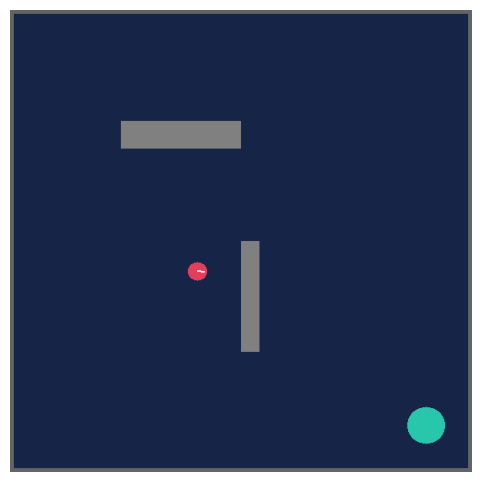

In [20]:
# Create environment with obstacles in state
env = PointParticleEnv()
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

def run_random_agent_animation(env, steps=500):
    frames = []
    state = env.reset()
    for _ in range(steps):
        # Sample a random action from the continuous action space
        action = env.action_space.sample()
        state, reward, done,_,info = env.step(action)
        frame = env.render(mode='rgb_array')
        frames.append(frame)
        if done:
            break
    return frames

# Create environment instance (with obstacles and continuous actions)
env = PointParticleEnv(obs=True)

# Run the agent for 50 random steps and collect frames
frames = run_random_agent_animation(env, steps=150)

# Create animation using matplotlib
fig, ax = plt.subplots(figsize=(6, 6))
ax.axis('off')
im = ax.imshow(frames[0])

def update(frame):
    im.set_data(frame)
    return [im]

anim = animation.FuncAnimation(fig, update, frames=frames, interval=100, blit=True)

# Display animation as HTML video (for Jupyter notebooks)
HTML(anim.to_html5_video())



In [17]:
import os
import wandb
# import gym
import json
import torch
import numpy as np
from tqdm import tqdm
from src.utils import *
from src.memory import *
from src.agents import *

os.environ['WANDB_API_KEY'] = ''
class Trainer:

    def __init__(self, config_file, enable_logging=True):
        self.enable_logging = enable_logging
        self.config = Trainer.parse_config(config_file)
        self.env =  gym.make(self.config['env_name'])
        self.env = apply_seed(self.env,self.config['seed'])
        self.state_dimension = self.env.observation_space.shape[0]
        print("state",self.state_dimension)
        self.action_dimension = self.env.action_space.shape[0]
        self.max_action = float(self.env.action_space.high[0])
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.agent = DDPGAgent(
            state_dim=self.state_dimension, action_dim=self.action_dimension,
            max_action=self.max_action, device=self.device,
            discount=self.config['discount'], tau=self.config['tau']
        )
        self.save_file_name = f"DDPG_{self.config['env_name']}_{self.config['seed']}"
        self.memory = ReplayBuffer()
        if self.enable_logging:
            wandb.init(project="ddpg", config=self.config)
        try:
            os.mkdir('./pretrained_models')
        except Exception as e:
            pass

    @staticmethod
    def parse_config(json_file):
        with open(json_file, 'r') as f:
            configs = json.load(f)
        return configs

    def train(self):
        # pull out your new config entries:
        num_episodes     = 300
        max_episode_steps = int(self.config.get('max_episode_steps', self.env._max_episode_steps))

        ts = 0                                 # global time-step counter
        episode_rewards = []
        evaluations     = []

        for ep in tqdm(range(1, num_episodes + 1)):
            print("episode number is: ",ep)
            state, info = self.env.reset()
            episode_reward, episode_timesteps = 0, 0
            done = False

            # run one episode (stop if env says done OR if we hit max_episode_steps)
            while not done and episode_timesteps < max_episode_steps:
                print("episode_timesteps: ",episode_timesteps)
                episode_timesteps += 1
                ts += 1

                # select action
                if ts < self.config['start_time_step']:
                    action = self.env.action_space.sample()
                else:
                    action = (
                        self.agent.select_action(np.array(state))
                        + np.random.normal(0, self.max_action * self.config['expl_noise'], size=self.action_dimension)
                    ).clip(-self.max_action, self.max_action)

                # step the env
                next_state, reward, done, trunc ,info = self.env.step(action)

                # push into replay, using 0‐mask if we ended because of time-limit
                time_limit_reached = (episode_timesteps >= max_episode_steps)
                mask = float(done) if not time_limit_reached else 0.0
                self.memory.push(state, action, reward, next_state, mask)

                state = next_state
                episode_reward += reward

                # train after warm-up
                if ts >= self.config['start_time_step']:
                    self.agent.train(self.memory, self.config['batch_size'])

            # end of this episode: logging + reset counters
            if self.enable_logging:
                wandb.log({'Episode': ep,
                          'Episode Reward': episode_reward,
                          'Episode Length': episode_timesteps,
                          'Global Step': ts})

            episode_rewards.append(episode_reward)

            # every 100 episodes, evaluate+checkpoint
            if ep % 10 == 0:
                eval_score = evaluate_policy(
                    self.agent,
                    self.config['env_name'],
                    self.config['seed'],
                    enable_logging=self.enable_logging,
                    wandb=wandb
                )
                evaluations.append(eval_score)
                self.agent.save_checkpoint(f"./pretrained_models/{self.save_file_name}")

        wandb.finish()
        return episode_rewards, evaluations


    def evaluate(self):
        self.agent.load_checkpoint(f"./pretrained_models/DDPG_{self.config['env_name']}_{self.config['seed']}")
        evaluate_policy(self.agent, self.config['env_name'], self.config['seed'],render=True)

In [18]:
# from train import Trainer
from matplotlib import pyplot as plt
# import gym
from gym.envs.registration import register
gym.register(
    id='PointParticle-v0',
    entry_point=PointParticleEnv,   # or "__main__:PointParticleEnv"
    max_episode_steps=500    # ← choose a sensible episode length
)


env_name='PointParticle-v0'
trainer = Trainer(config_file=f'./configs/{env_name}.json',enable_logging=True)
episode_rewards, evaluations = trainer.train()

plt.figure(figsize=(16, 10))
plt.plot(episode_rewards)

/usr/local/lib/python3.11/dist-packages/gym/envs/registration.py:498: UserWarning: WARN: Overriding environment PointParticle-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


state 3


  0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
  0%|          | 1/300 [00:00<00:44,  6.70it/s]

episode number is:  1
episode_timesteps:  0
episode_timesteps:  1
episode_timesteps:  2
episode_timesteps:  3
episode_timesteps:  4
episode_timesteps:  5
episode_timesteps:  6
episode_timesteps:  7
episode_timesteps:  8
episode_timesteps:  9
episode_timesteps:  10
episode_timesteps:  11
episode_timesteps:  12
episode_timesteps:  13
episode_timesteps:  14
episode_timesteps:  15
episode_timesteps:  16
episode_timesteps:  17
episode_timesteps:  18
episode_timesteps:  19
episode_timesteps:  20
episode_timesteps:  21
episode_timesteps:  22
episode_timesteps:  23
episode_timesteps:  24
episode_timesteps:  25
episode_timesteps:  26
episode_timesteps:  27
episode_timesteps:  28
episode_timesteps:  29
episode_timesteps:  30
episode_timesteps:  31
episode_timesteps:  32
episode_timesteps:  33
episode_timesteps:  34
episode_timesteps:  35
episode_timesteps:  36
episode_timesteps:  37
episode_timesteps:  38
episode_timesteps:  39
episode_timesteps:  40
episode_timesteps:  41
episode_timesteps:  42

  1%|          | 2/300 [00:00<00:49,  6.05it/s]

episode_timesteps:  21
episode_timesteps:  22
episode_timesteps:  23
episode_timesteps:  24
episode_timesteps:  25
episode_timesteps:  26
episode_timesteps:  27
episode_timesteps:  28
episode_timesteps:  29
episode_timesteps:  30
episode_timesteps:  31
episode_timesteps:  32
episode_timesteps:  33
episode_timesteps:  34
episode_timesteps:  35
episode_timesteps:  36
episode_timesteps:  37
episode_timesteps:  38
episode_timesteps:  39
episode_timesteps:  40
episode_timesteps:  41
episode_timesteps:  42
episode_timesteps:  43
episode_timesteps:  44
episode_timesteps:  45
episode_timesteps:  46
episode_timesteps:  47
episode_timesteps:  48
episode_timesteps:  49
episode_timesteps:  50
episode_timesteps:  51
episode_timesteps:  52
episode_timesteps:  53
episode_timesteps:  54
episode_timesteps:  55
episode_timesteps:  56
episode_timesteps:  57
episode_timesteps:  58
episode_timesteps:  59
episode_timesteps:  60
episode_timesteps:  61
episode_timesteps:  62
episode_timesteps:  63
episode_tim

  1%|          | 3/300 [00:00<00:57,  5.20it/s]

 77
episode_timesteps:  78
episode_timesteps:  79
episode_timesteps:  80
episode_timesteps:  81
episode_timesteps:  82
episode_timesteps:  83
episode_timesteps:  84
episode_timesteps:  85
episode_timesteps:  86
episode_timesteps:  87
episode_timesteps:  88
episode_timesteps:  89
episode_timesteps:  90
episode_timesteps:  91
episode_timesteps:  92
episode_timesteps:  93
episode_timesteps:  94
episode_timesteps:  95
episode_timesteps:  96
episode_timesteps:  97
episode_timesteps:  98
episode_timesteps:  99
episode_timesteps:  100
episode_timesteps:  101
episode_timesteps:  102
episode_timesteps:  103
episode_timesteps:  104
episode_timesteps:  105
episode_timesteps:  106
episode_timesteps:  107
episode_timesteps:  108
episode_timesteps:  109
episode_timesteps:  110
episode_timesteps:  111
episode_timesteps:  112
episode_timesteps:  113
episode_timesteps:  114
episode_timesteps:  115
episode_timesteps:  116
episode_timesteps:  117
episode_timesteps:  118
episode_timesteps:  119
episode_ti

  1%|▏         | 4/300 [00:00<01:00,  4.91it/s]

 84
episode_timesteps:  85
episode_timesteps:  86
episode_timesteps:  87
episode_timesteps:  88
episode_timesteps:  89
episode_timesteps:  90
episode_timesteps:  91
episode_timesteps:  92
episode_timesteps:  93
episode_timesteps:  94
episode_timesteps:  95
episode_timesteps:  96
episode_timesteps:  97
episode_timesteps:  98
episode_timesteps:  99
episode_timesteps:  100
episode_timesteps:  101
episode_timesteps:  102
episode_timesteps:  103
episode_timesteps:  104
episode_timesteps:  105
episode_timesteps:  106
episode_timesteps:  107
episode_timesteps:  108
episode_timesteps:  109
episode_timesteps:  110
episode_timesteps:  111
episode_timesteps:  112
episode_timesteps:  113
episode_timesteps:  114
episode_timesteps:  115
episode_timesteps:  116
episode_timesteps:  117
episode_timesteps:  118
episode_timesteps:  119
episode_timesteps:  120
episode_timesteps:  121
episode_timesteps:  122
episode_timesteps:  123
episode_timesteps:  124
episode_timesteps:  125
episode_timesteps:  126
epi

  2%|▏         | 6/300 [00:01<00:48,  6.05it/s]

2
episode_timesteps:  3
episode_timesteps:  4
episode_timesteps:  5
episode_timesteps:  6
episode_timesteps:  7
episode_timesteps:  8
episode_timesteps:  9
episode_timesteps:  10
episode_timesteps:  11
episode_timesteps:  12
episode_timesteps:  13
episode_timesteps:  14
episode_timesteps:  15
episode_timesteps:  16
episode_timesteps:  17
episode_timesteps:  18
episode_timesteps:  19
episode_timesteps:  20
episode_timesteps:  21
episode_timesteps:  22
episode_timesteps:  23
episode_timesteps:  24
episode_timesteps:  25
episode_timesteps:  26
episode_timesteps:  27
episode_timesteps:  28
episode_timesteps:  29
episode_timesteps:  30
episode_timesteps:  31
episode_timesteps:  32
episode_timesteps:  33
episode_timesteps:  34
episode_timesteps:  35
episode_timesteps:  36
episode_timesteps:  37
episode_timesteps:  38
episode_timesteps:  39
episode_timesteps:  40
episode_timesteps:  41
episode_timesteps:  42
episode_timesteps:  43
episode_timesteps:  44
episode_timesteps:  45
episode_timestep

  2%|▏         | 7/300 [00:01<00:44,  6.52it/s]

episode_timesteps:  11
episode_timesteps:  12
episode_timesteps:  13
episode_timesteps:  14
episode_timesteps:  15
episode_timesteps:  16
episode_timesteps:  17
episode_timesteps:  18
episode_timesteps:  19
episode_timesteps:  20
episode_timesteps:  21
episode_timesteps:  22
episode_timesteps:  23
episode_timesteps:  24
episode_timesteps:  25
episode_timesteps:  26
episode_timesteps:  27
episode_timesteps:  28
episode_timesteps:  29
episode_timesteps:  30
episode_timesteps:  31
episode_timesteps:  32
episode_timesteps:  33
episode_timesteps:  34
episode_timesteps:  35
episode_timesteps:  36
episode_timesteps:  37
episode_timesteps:  38
episode_timesteps:  39
episode_timesteps:  40
episode_timesteps:  41
episode_timesteps:  42
episode_timesteps:  43
episode_timesteps:  44
episode_timesteps:  45
episode_timesteps:  46
episode_timesteps:  47
episode_timesteps:  48
episode_timesteps:  49
episode_timesteps:  50
episode_timesteps:  51
episode_timesteps:  52
episode_timesteps:  53
episode_tim

  3%|▎         | 8/300 [00:01<01:16,  3.81it/s]

episode_timesteps:  463
episode_timesteps:  464
episode_timesteps:  465
episode_timesteps:  466
episode_timesteps:  467
episode_timesteps:  468
episode_timesteps:  469
episode_timesteps:  470
episode_timesteps:  471
episode_timesteps:  472
episode_timesteps:  473
episode_timesteps:  474
episode_timesteps:  475
episode_timesteps:  476
episode_timesteps:  477
episode_timesteps:  478
episode_timesteps:  479
episode_timesteps:  480
episode_timesteps:  481
episode_timesteps:  482
episode_timesteps:  483
episode_timesteps:  484
episode_timesteps:  485
episode_timesteps:  486
episode_timesteps:  487
episode_timesteps:  488
episode number is:  9
episode_timesteps:  0
episode_timesteps:  1
episode_timesteps:  2
episode_timesteps:  3
episode_timesteps:  4
episode_timesteps:  5
episode_timesteps:  6
episode_timesteps:  7
episode_timesteps:  8
episode_timesteps:  9
episode_timesteps:  10
episode_timesteps:  11
episode_timesteps:  12
episode_timesteps:  13
episode_timesteps:  14
episode_timesteps: 

  3%|▎         | 9/300 [00:02<01:24,  3.43it/s]

 117
episode_timesteps:  118
episode_timesteps:  119
episode_timesteps:  120
episode_timesteps:  121
episode_timesteps:  122
episode_timesteps:  123
episode_timesteps:  124
episode_timesteps:  125
episode_timesteps:  126
episode_timesteps:  127
episode_timesteps:  128
episode_timesteps:  129
episode_timesteps:  130
episode_timesteps:  131
episode_timesteps:  132
episode_timesteps:  133
episode_timesteps:  134
episode_timesteps:  135
episode_timesteps:  136
episode_timesteps:  137
episode_timesteps:  138
episode_timesteps:  139
episode_timesteps:  140
episode_timesteps:  141
episode_timesteps:  142
episode_timesteps:  143
episode_timesteps:  144
episode_timesteps:  145
episode_timesteps:  146
episode_timesteps:  147
episode_timesteps:  148
episode_timesteps:  149
episode_timesteps:  150
episode_timesteps:  151
episode_timesteps:  152
episode_timesteps:  153
episode_timesteps:  154
episode_timesteps:  155
episode_timesteps:  156
episode_timesteps:  157
episode_timesteps:  158
episode_tim

  3%|▎         | 10/300 [00:07<08:26,  1.75s/it]

Episode reward 10 ==> -26795.858840942383
episode number is:  11
episode_timesteps:  0
episode_timesteps:  1
episode_timesteps:  2
episode_timesteps:  3
episode_timesteps:  4
episode_timesteps:  5
episode_timesteps:  6
episode_timesteps:  7
episode_timesteps:  8
episode_timesteps:  9
episode_timesteps:  10
episode_timesteps:  11
episode_timesteps:  12
episode_timesteps:  13
episode_timesteps:  14
episode_timesteps:  15
episode_timesteps:  16
episode_timesteps:  17
episode_timesteps:  18
episode_timesteps:  19
episode_timesteps:  20
episode_timesteps:  21
episode_timesteps:  22
episode_timesteps:  23
episode_timesteps:  24
episode_timesteps:  25
episode_timesteps:  26
episode_timesteps:  27
episode_timesteps:  28
episode_timesteps:  29
episode_timesteps:  30
episode_timesteps:  31
episode_timesteps:  32
episode_timesteps:  33
episode_timesteps:  34
episode_timesteps:  35
episode_timesteps:  36
episode_timesteps:  37
episode_timesteps:  38
episode_timesteps:  39
episode_timesteps:  40
ep

  4%|▎         | 11/300 [00:07<06:37,  1.37s/it]


episode_timesteps:  180
episode_timesteps:  181
episode_timesteps:  182
episode_timesteps:  183
episode_timesteps:  184
episode_timesteps:  185
episode_timesteps:  186
episode_timesteps:  187
episode_timesteps:  188
episode_timesteps:  189
episode_timesteps:  190
episode_timesteps:  191
episode_timesteps:  192
episode_timesteps:  193
episode_timesteps:  194
episode_timesteps:  195
episode_timesteps:  196
episode_timesteps:  197
episode_timesteps:  198
episode_timesteps:  199
episode_timesteps:  200
episode_timesteps:  201
episode_timesteps:  202
episode_timesteps:  203
episode_timesteps:  204
episode_timesteps:  205
episode_timesteps:  206
episode_timesteps:  207
episode_timesteps:  208
episode_timesteps:  209
episode_timesteps:  210
episode_timesteps:  211
episode_timesteps:  212
episode_timesteps:  213
episode_timesteps:  214
episode_timesteps:  215
episode_timesteps:  216
episode_timesteps:  217
episode_timesteps:  218
episode_timesteps:  219
episode_timesteps:  220
episode_timeste

  4%|▍         | 12/300 [00:08<05:18,  1.11s/it]

episode_timesteps:  285
episode_timesteps:  286
episode_timesteps:  287
episode_timesteps:  288
episode_timesteps:  289
episode_timesteps:  290
episode_timesteps:  291
episode_timesteps:  292
episode_timesteps:  293
episode_timesteps:  294
episode_timesteps:  295
episode_timesteps:  296
episode_timesteps:  297
episode_timesteps:  298
episode_timesteps:  299
episode_timesteps:  300
episode_timesteps:  301
episode_timesteps:  302
episode_timesteps:  303
episode_timesteps:  304
episode_timesteps:  305
episode_timesteps:  306
episode_timesteps:  307
episode_timesteps:  308
episode_timesteps:  309
episode_timesteps:  310
episode_timesteps:  311
episode_timesteps:  312
episode_timesteps:  313
episode_timesteps:  314
episode_timesteps:  315
episode_timesteps:  316
episode_timesteps:  317
episode_timesteps:  318
episode_timesteps:  319
episode_timesteps:  320
episode_timesteps:  321
episode_timesteps:  322
episode_timesteps:  323
episode_timesteps:  324
episode_timesteps:  325
episode_timestep

  4%|▍         | 13/300 [00:08<04:28,  1.07it/s]

 402
episode_timesteps:  403
episode_timesteps:  404
episode_timesteps:  405
episode_timesteps:  406
episode_timesteps:  407
episode_timesteps:  408
episode_timesteps:  409
episode_timesteps:  410
episode_timesteps:  411
episode_timesteps:  412
episode_timesteps:  413
episode_timesteps:  414
episode_timesteps:  415
episode_timesteps:  416
episode_timesteps:  417
episode_timesteps:  418
episode_timesteps:  419
episode_timesteps:  420
episode_timesteps:  421
episode_timesteps:  422
episode_timesteps:  423
episode_timesteps:  424
episode_timesteps:  425
episode_timesteps:  426
episode_timesteps:  427
episode_timesteps:  428
episode_timesteps:  429
episode_timesteps:  430
episode_timesteps:  431
episode_timesteps:  432
episode_timesteps:  433
episode_timesteps:  434
episode_timesteps:  435
episode_timesteps:  436
episode_timesteps:  437
episode_timesteps:  438
episode_timesteps:  439
episode_timesteps:  440
episode_timesteps:  441
episode_timesteps:  442
episode_timesteps:  443
episode_tim

  5%|▌         | 15/300 [00:09<02:36,  1.82it/s]

episode_timesteps:  54
episode_timesteps:  55
episode_timesteps:  56
episode_timesteps:  57
episode_timesteps:  58
episode_timesteps:  59
episode_timesteps:  60
episode_timesteps:  61
episode_timesteps:  62
episode_timesteps:  63
episode_timesteps:  64
episode_timesteps:  65
episode_timesteps:  66
episode_timesteps:  67
episode_timesteps:  68
episode_timesteps:  69
episode_timesteps:  70
episode_timesteps:  71
episode_timesteps:  72
episode_timesteps:  73
episode_timesteps:  74
episode_timesteps:  75
episode_timesteps:  76
episode_timesteps:  77
episode_timesteps:  78
episode_timesteps:  79
episode_timesteps:  80
episode_timesteps:  81
episode_timesteps:  82
episode_timesteps:  83
episode_timesteps:  84
episode_timesteps:  85
episode_timesteps:  86
episode_timesteps:  87
episode_timesteps:  88
episode_timesteps:  89
episode_timesteps:  90
episode_timesteps:  91
episode_timesteps:  92
episode_timesteps:  93
episode_timesteps:  94
episode_timesteps:  95
episode_timesteps:  96
episode_tim

  5%|▌         | 16/300 [00:09<02:22,  2.00it/s]

317
episode_timesteps:  318
episode_timesteps:  319
episode_timesteps:  320
episode_timesteps:  321
episode_timesteps:  322
episode_timesteps:  323
episode_timesteps:  324
episode_timesteps:  325
episode_timesteps:  326
episode_timesteps:  327
episode_timesteps:  328
episode_timesteps:  329
episode_timesteps:  330
episode_timesteps:  331
episode_timesteps:  332
episode_timesteps:  333
episode_timesteps:  334
episode_timesteps:  335
episode_timesteps:  336
episode_timesteps:  337
episode_timesteps:  338
episode number is:  17
episode_timesteps:  0
episode_timesteps:  1
episode_timesteps:  2
episode_timesteps:  3
episode_timesteps:  4
episode_timesteps:  5
episode_timesteps:  6
episode_timesteps:  7
episode_timesteps:  8
episode_timesteps:  9
episode_timesteps:  10
episode_timesteps:  11
episode_timesteps:  12
episode_timesteps:  13
episode_timesteps:  14
episode_timesteps:  15
episode_timesteps:  16
episode_timesteps:  17
episode_timesteps:  18
episode_timesteps:  19
episode_timesteps: 

  6%|▌         | 17/300 [00:09<02:19,  2.03it/s]

 433
episode_timesteps:  434
episode_timesteps:  435
episode_timesteps:  436
episode_timesteps:  437
episode_timesteps:  438
episode_timesteps:  439
episode_timesteps:  440
episode_timesteps:  441
episode_timesteps:  442
episode_timesteps:  443
episode_timesteps:  444
episode_timesteps:  445
episode_timesteps:  446
episode_timesteps:  447
episode_timesteps:  448
episode_timesteps:  449
episode_timesteps:  450
episode_timesteps:  451
episode_timesteps:  452
episode_timesteps:  453
episode_timesteps:  454
episode_timesteps:  455
episode_timesteps:  456
episode_timesteps:  457
episode_timesteps:  458
episode_timesteps:  459
episode_timesteps:  460
episode_timesteps:  461
episode_timesteps:  462
episode_timesteps:  463
episode_timesteps:  464
episode_timesteps:  465
episode_timesteps:  466
episode_timesteps:  467
episode_timesteps:  468
episode_timesteps:  469
episode_timesteps:  470
episode_timesteps:  471
episode_timesteps:  472
episode_timesteps:  473
episode_timesteps:  474
episode_tim

  6%|▌         | 18/300 [00:10<01:56,  2.42it/s]

 102
episode_timesteps:  103
episode_timesteps:  104
episode_timesteps:  105
episode_timesteps:  106
episode_timesteps:  107
episode_timesteps:  108
episode_timesteps:  109
episode_timesteps:  110
episode_timesteps:  111
episode_timesteps:  112
episode_timesteps:  113
episode_timesteps:  114
episode_timesteps:  115
episode_timesteps:  116
episode_timesteps:  117
episode_timesteps:  118
episode_timesteps:  119
episode_timesteps:  120
episode_timesteps:  121
episode_timesteps:  122
episode_timesteps:  123
episode_timesteps:  124
episode_timesteps:  125
episode_timesteps:  126
episode_timesteps:  127
episode_timesteps:  128
episode_timesteps:  129
episode_timesteps:  130
episode_timesteps:  131
episode_timesteps:  132
episode_timesteps:  133
episode_timesteps:  134
episode_timesteps:  135
episode_timesteps:  136
episode_timesteps:  137
episode_timesteps:  138
episode_timesteps:  139
episode_timesteps:  140
episode_timesteps:  141
episode_timesteps:  142
episode_timesteps:  143
episode_tim

  6%|▋         | 19/300 [00:10<01:49,  2.58it/s]

 106
episode_timesteps:  107
episode_timesteps:  108
episode_timesteps:  109
episode_timesteps:  110
episode_timesteps:  111
episode_timesteps:  112
episode_timesteps:  113
episode_timesteps:  114
episode_timesteps:  115
episode_timesteps:  116
episode_timesteps:  117
episode_timesteps:  118
episode_timesteps:  119
episode_timesteps:  120
episode_timesteps:  121
episode_timesteps:  122
episode_timesteps:  123
episode_timesteps:  124
episode_timesteps:  125
episode_timesteps:  126
episode_timesteps:  127
episode_timesteps:  128
episode_timesteps:  129
episode_timesteps:  130
episode_timesteps:  131
episode_timesteps:  132
episode_timesteps:  133
episode_timesteps:  134
episode_timesteps:  135
episode_timesteps:  136
episode_timesteps:  137
episode_timesteps:  138
episode_timesteps:  139
episode_timesteps:  140
episode_timesteps:  141
episode_timesteps:  142
episode_timesteps:  143
episode_timesteps:  144
episode_timesteps:  145
episode_timesteps:  146
episode_timesteps:  147
episode_tim

  7%|▋         | 20/300 [00:13<06:07,  1.31s/it]

Episode reward 10 ==> -26795.858840942383
episode number is:  21
episode_timesteps:  0
episode_timesteps:  1
episode_timesteps:  2
episode_timesteps:  3
episode_timesteps:  4
episode_timesteps:  5
episode_timesteps:  6
episode_timesteps:  7
episode_timesteps:  8
episode_timesteps:  9
episode_timesteps:  10
episode_timesteps:  11
episode_timesteps:  12
episode_timesteps:  13
episode_timesteps:  14
episode_timesteps:  15
episode_timesteps:  16
episode_timesteps:  17
episode_timesteps:  18
episode_timesteps:  19
episode_timesteps:  20
episode_timesteps:  21
episode_timesteps:  22
episode_timesteps:  23
episode_timesteps:  24
episode_timesteps:  25
episode_timesteps:  26
episode_timesteps:  27
episode_timesteps:  28
episode_timesteps:  29
episode_timesteps:  30
episode_timesteps:  31
episode_timesteps:  32
episode_timesteps:  33
episode_timesteps:  34
episode_timesteps:  35
episode_timesteps:  36
episode_timesteps:  37
episode_timesteps:  38
episode_timesteps:  39
episode_timesteps:  40
ep

  7%|▋         | 21/300 [00:14<04:44,  1.02s/it]

episode_timesteps:  131
episode_timesteps:  132
episode_timesteps:  133
episode_timesteps:  134
episode_timesteps:  135
episode_timesteps:  136
episode_timesteps:  137
episode_timesteps:  138
episode_timesteps:  139
episode_timesteps:  140
episode_timesteps:  141
episode_timesteps:  142
episode_timesteps:  143
episode_timesteps:  144
episode_timesteps:  145
episode_timesteps:  146
episode_timesteps:  147
episode_timesteps:  148
episode_timesteps:  149
episode_timesteps:  150
episode_timesteps:  151
episode_timesteps:  152
episode_timesteps:  153
episode_timesteps:  154
episode_timesteps:  155
episode_timesteps:  156
episode_timesteps:  157
episode_timesteps:  158
episode_timesteps:  159
episode_timesteps:  160
episode_timesteps:  161
episode_timesteps:  162
episode_timesteps:  163
episode_timesteps:  164
episode_timesteps:  165
episode_timesteps:  166
episode_timesteps:  167
episode_timesteps:  168
episode_timesteps:  169
episode_timesteps:  170
episode_timesteps:  171
episode_timestep

  7%|▋         | 22/300 [00:14<03:48,  1.22it/s]

 188
episode_timesteps:  189
episode_timesteps:  190
episode_timesteps:  191
episode_timesteps:  192
episode_timesteps:  193
episode_timesteps:  194
episode_timesteps:  195
episode_timesteps:  196
episode_timesteps:  197
episode_timesteps:  198
episode_timesteps:  199
episode_timesteps:  200
episode_timesteps:  201
episode_timesteps:  202
episode_timesteps:  203
episode_timesteps:  204
episode_timesteps:  205
episode_timesteps:  206
episode_timesteps:  207
episode_timesteps:  208
episode_timesteps:  209
episode_timesteps:  210
episode_timesteps:  211
episode_timesteps:  212
episode_timesteps:  213
episode_timesteps:  214
episode_timesteps:  215
episode_timesteps:  216
episode_timesteps:  217
episode_timesteps:  218
episode_timesteps:  219
episode_timesteps:  220
episode_timesteps:  221
episode_timesteps:  222
episode_timesteps:  223
episode_timesteps:  224
episode_timesteps:  225
episode_timesteps:  226
episode_timesteps:  227
episode_timesteps:  228
episode_timesteps:  229
episode_tim

  8%|▊         | 23/300 [00:15<03:13,  1.43it/s]

253
episode_timesteps:  254
episode_timesteps:  255
episode_timesteps:  256
episode_timesteps:  257
episode_timesteps:  258
episode_timesteps:  259
episode_timesteps:  260
episode_timesteps:  261
episode_timesteps:  262
episode_timesteps:  263
episode_timesteps:  264
episode_timesteps:  265
episode_timesteps:  266
episode_timesteps:  267
episode_timesteps:  268
episode_timesteps:  269
episode_timesteps:  270
episode_timesteps:  271
episode_timesteps:  272
episode_timesteps:  273
episode_timesteps:  274
episode_timesteps:  275
episode_timesteps:  276
episode_timesteps:  277
episode_timesteps:  278
episode_timesteps:  279
episode_timesteps:  280
episode_timesteps:  281
episode_timesteps:  282
episode_timesteps:  283
episode_timesteps:  284
episode_timesteps:  285
episode_timesteps:  286
episode_timesteps:  287
episode_timesteps:  288
episode_timesteps:  289
episode_timesteps:  290
episode_timesteps:  291
episode_timesteps:  292
episode_timesteps:  293
episode_timesteps:  294
episode_time

  8%|▊         | 24/300 [00:15<02:52,  1.60it/s]

 371
episode_timesteps:  372
episode_timesteps:  373
episode_timesteps:  374
episode_timesteps:  375
episode_timesteps:  376
episode_timesteps:  377
episode_timesteps:  378
episode_timesteps:  379
episode_timesteps:  380
episode_timesteps:  381
episode_timesteps:  382
episode_timesteps:  383
episode_timesteps:  384
episode_timesteps:  385
episode_timesteps:  386
episode_timesteps:  387
episode_timesteps:  388
episode_timesteps:  389
episode_timesteps:  390
episode_timesteps:  391
episode_timesteps:  392
episode_timesteps:  393
episode_timesteps:  394
episode_timesteps:  395
episode_timesteps:  396
episode_timesteps:  397
episode_timesteps:  398
episode_timesteps:  399
episode_timesteps:  400
episode_timesteps:  401
episode_timesteps:  402
episode_timesteps:  403
episode_timesteps:  404
episode_timesteps:  405
episode_timesteps:  406
episode_timesteps:  407
episode_timesteps:  408
episode_timesteps:  409
episode_timesteps:  410
episode_timesteps:  411
episode_timesteps:  412
episode_tim

  8%|▊         | 25/300 [00:16<02:51,  1.60it/s]

episode_timesteps:  419
episode_timesteps:  420
episode_timesteps:  421
episode_timesteps:  422
episode_timesteps:  423
episode_timesteps:  424
episode_timesteps:  425
episode_timesteps:  426
episode_timesteps:  427
episode_timesteps:  428
episode_timesteps:  429
episode_timesteps:  430
episode_timesteps:  431
episode_timesteps:  432
episode_timesteps:  433
episode_timesteps:  434
episode_timesteps:  435
episode_timesteps:  436
episode_timesteps:  437
episode_timesteps:  438
episode_timesteps:  439
episode_timesteps:  440
episode_timesteps:  441
episode_timesteps:  442
episode_timesteps:  443
episode_timesteps:  444
episode_timesteps:  445
episode_timesteps:  446
episode_timesteps:  447
episode_timesteps:  448
episode_timesteps:  449
episode_timesteps:  450
episode_timesteps:  451
episode_timesteps:  452
episode_timesteps:  453
episode_timesteps:  454
episode_timesteps:  455
episode_timesteps:  456
episode_timesteps:  457
episode_timesteps:  458
episode_timesteps:  459
episode_timestep

  9%|▊         | 26/300 [00:16<02:50,  1.61it/s]

episode_timesteps:  430
episode_timesteps:  431
episode_timesteps:  432
episode_timesteps:  433
episode_timesteps:  434
episode_timesteps:  435
episode_timesteps:  436
episode_timesteps:  437
episode_timesteps:  438
episode_timesteps:  439
episode_timesteps:  440
episode_timesteps:  441
episode_timesteps:  442
episode_timesteps:  443
episode_timesteps:  444
episode_timesteps:  445
episode_timesteps:  446
episode_timesteps:  447
episode_timesteps:  448
episode_timesteps:  449
episode_timesteps:  450
episode_timesteps:  451
episode_timesteps:  452
episode_timesteps:  453
episode_timesteps:  454
episode_timesteps:  455
episode_timesteps:  456
episode_timesteps:  457
episode_timesteps:  458
episode_timesteps:  459
episode_timesteps:  460
episode_timesteps:  461
episode_timesteps:  462
episode_timesteps:  463
episode_timesteps:  464
episode_timesteps:  465
episode_timesteps:  466
episode_timesteps:  467
episode_timesteps:  468
episode_timesteps:  469
episode_timesteps:  470
episode_timestep

  9%|▉         | 27/300 [00:16<02:18,  1.98it/s]

 66
episode_timesteps:  67
episode_timesteps:  68
episode_timesteps:  69
episode_timesteps:  70
episode_timesteps:  71
episode_timesteps:  72
episode_timesteps:  73
episode_timesteps:  74
episode_timesteps:  75
episode_timesteps:  76
episode_timesteps:  77
episode_timesteps:  78
episode_timesteps:  79
episode_timesteps:  80
episode_timesteps:  81
episode_timesteps:  82
episode_timesteps:  83
episode_timesteps:  84
episode_timesteps:  85
episode_timesteps:  86
episode_timesteps:  87
episode_timesteps:  88
episode_timesteps:  89
episode_timesteps:  90
episode_timesteps:  91
episode_timesteps:  92
episode_timesteps:  93
episode_timesteps:  94
episode_timesteps:  95
episode_timesteps:  96
episode_timesteps:  97
episode_timesteps:  98
episode_timesteps:  99
episode_timesteps:  100
episode_timesteps:  101
episode_timesteps:  102
episode_timesteps:  103
episode_timesteps:  104
episode_timesteps:  105
episode_timesteps:  106
episode_timesteps:  107
episode_timesteps:  108
episode_timesteps:  1

  9%|▉         | 28/300 [00:17<02:32,  1.78it/s]

episode_timesteps:  374
episode_timesteps:  375
episode_timesteps:  376
episode_timesteps:  377
episode_timesteps:  378
episode_timesteps:  379
episode_timesteps:  380
episode_timesteps:  381
episode_timesteps:  382
episode_timesteps:  383
episode_timesteps:  384
episode_timesteps:  385
episode_timesteps:  386
episode_timesteps:  387
episode_timesteps:  388
episode_timesteps:  389
episode_timesteps:  390
episode_timesteps:  391
episode_timesteps:  392
episode_timesteps:  393
episode_timesteps:  394
episode_timesteps:  395
episode_timesteps:  396
episode_timesteps:  397
episode_timesteps:  398
episode_timesteps:  399
episode_timesteps:  400
episode_timesteps:  401
episode_timesteps:  402
episode_timesteps:  403
episode_timesteps:  404
episode_timesteps:  405
episode_timesteps:  406
episode_timesteps:  407
episode_timesteps:  408
episode_timesteps:  409
episode_timesteps:  410
episode_timesteps:  411
episode_timesteps:  412
episode_timesteps:  413
episode_timesteps:  414
episode_timestep

 10%|▉         | 29/300 [00:18<02:52,  1.57it/s]

episode_timesteps:  380
episode_timesteps:  381
episode_timesteps:  382
episode_timesteps:  383
episode_timesteps:  384
episode_timesteps:  385
episode_timesteps:  386
episode_timesteps:  387
episode_timesteps:  388
episode_timesteps:  389
episode_timesteps:  390
episode_timesteps:  391
episode_timesteps:  392
episode_timesteps:  393
episode_timesteps:  394
episode_timesteps:  395
episode_timesteps:  396
episode_timesteps:  397
episode_timesteps:  398
episode_timesteps:  399
episode_timesteps:  400
episode_timesteps:  401
episode_timesteps:  402
episode_timesteps:  403
episode_timesteps:  404
episode_timesteps:  405
episode_timesteps:  406
episode_timesteps:  407
episode_timesteps:  408
episode_timesteps:  409
episode_timesteps:  410
episode_timesteps:  411
episode_timesteps:  412
episode_timesteps:  413
episode_timesteps:  414
episode_timesteps:  415
episode_timesteps:  416
episode_timesteps:  417
episode_timesteps:  418
episode_timesteps:  419
episode_timesteps:  420
episode_timestep

 10%|█         | 30/300 [00:25<11:17,  2.51s/it]

Episode reward 10 ==> -26795.858840942383
episode number is:  31
episode_timesteps:  0
episode_timesteps:  1
episode_timesteps:  2
episode_timesteps:  3
episode_timesteps:  4
episode_timesteps:  5
episode_timesteps:  6
episode_timesteps:  7
episode_timesteps:  8
episode_timesteps:  9
episode_timesteps:  10
episode_timesteps:  11
episode_timesteps:  12
episode_timesteps:  13
episode_timesteps:  14
episode_timesteps:  15
episode_timesteps:  16
episode_timesteps:  17
episode_timesteps:  18
episode_timesteps:  19
episode_timesteps:  20
episode_timesteps:  21
episode_timesteps:  22
episode_timesteps:  23
episode_timesteps:  24
episode_timesteps:  25
episode_timesteps:  26
episode_timesteps:  27
episode_timesteps:  28
episode_timesteps:  29
episode_timesteps:  30
episode_timesteps:  31
episode_timesteps:  32
episode_timesteps:  33
episode_timesteps:  34
episode_timesteps:  35
episode_timesteps:  36
episode_timesteps:  37
episode_timesteps:  38
episode_timesteps:  39
episode_timesteps:  40
ep

 10%|█         | 31/300 [00:26<08:47,  1.96s/it]


episode_timesteps:  439
episode_timesteps:  440
episode_timesteps:  441
episode_timesteps:  442
episode_timesteps:  443
episode_timesteps:  444
episode_timesteps:  445
episode_timesteps:  446
episode_timesteps:  447
episode_timesteps:  448
episode_timesteps:  449
episode_timesteps:  450
episode_timesteps:  451
episode_timesteps:  452
episode_timesteps:  453
episode_timesteps:  454
episode_timesteps:  455
episode_timesteps:  456
episode_timesteps:  457
episode_timesteps:  458
episode_timesteps:  459
episode_timesteps:  460
episode_timesteps:  461
episode_timesteps:  462
episode_timesteps:  463
episode_timesteps:  464
episode_timesteps:  465
episode_timesteps:  466
episode_timesteps:  467
episode_timesteps:  468
episode_timesteps:  469
episode_timesteps:  470
episode_timesteps:  471
episode_timesteps:  472
episode_timesteps:  473
episode_timesteps:  474
episode_timesteps:  475
episode_timesteps:  476
episode_timesteps:  477
episode_timesteps:  478
episode_timesteps:  479
episode_timeste

 11%|█         | 32/300 [00:26<06:17,  1.41s/it]

102
episode_timesteps:  103
episode_timesteps:  104
episode_timesteps:  105
episode_timesteps:  106
episode_timesteps:  107
episode_timesteps:  108
episode_timesteps:  109
episode_timesteps:  110
episode_timesteps:  111
episode_timesteps:  112
episode_timesteps:  113
episode_timesteps:  114
episode_timesteps:  115
episode_timesteps:  116
episode_timesteps:  117
episode_timesteps:  118
episode_timesteps:  119
episode_timesteps:  120
episode_timesteps:  121
episode_timesteps:  122
episode_timesteps:  123
episode_timesteps:  124
episode_timesteps:  125
episode_timesteps:  126
episode_timesteps:  127
episode_timesteps:  128
episode_timesteps:  129
episode_timesteps:  130
episode_timesteps:  131
episode_timesteps:  132
episode_timesteps:  133
episode_timesteps:  134
episode_timesteps:  135
episode_timesteps:  136
episode_timesteps:  137
episode_timesteps:  138
episode_timesteps:  139
episode number is:  33
episode_timesteps:  0
episode_timesteps:  1
episode_timesteps:  2
episode_timesteps: 

 11%|█         | 33/300 [00:26<04:58,  1.12s/it]


episode_timesteps:  447
episode_timesteps:  448
episode_timesteps:  449
episode_timesteps:  450
episode_timesteps:  451
episode_timesteps:  452
episode_timesteps:  453
episode_timesteps:  454
episode_timesteps:  455
episode_timesteps:  456
episode_timesteps:  457
episode_timesteps:  458
episode_timesteps:  459
episode_timesteps:  460
episode_timesteps:  461
episode_timesteps:  462
episode_timesteps:  463
episode_timesteps:  464
episode_timesteps:  465
episode_timesteps:  466
episode_timesteps:  467
episode_timesteps:  468
episode_timesteps:  469
episode_timesteps:  470
episode_timesteps:  471
episode_timesteps:  472
episode_timesteps:  473
episode_timesteps:  474
episode_timesteps:  475
episode_timesteps:  476
episode_timesteps:  477
episode_timesteps:  478
episode_timesteps:  479
episode_timesteps:  480
episode_timesteps:  481
episode_timesteps:  482
episode_timesteps:  483
episode_timesteps:  484
episode_timesteps:  485
episode_timesteps:  486
episode_timesteps:  487
episode_timeste

 11%|█▏        | 34/300 [00:27<04:18,  1.03it/s]

444
episode_timesteps:  445
episode_timesteps:  446
episode_timesteps:  447
episode_timesteps:  448
episode_timesteps:  449
episode_timesteps:  450
episode_timesteps:  451
episode_timesteps:  452
episode_timesteps:  453
episode_timesteps:  454
episode_timesteps:  455
episode_timesteps:  456
episode_timesteps:  457
episode_timesteps:  458
episode_timesteps:  459
episode_timesteps:  460
episode_timesteps:  461
episode_timesteps:  462
episode_timesteps:  463
episode_timesteps:  464
episode_timesteps:  465
episode_timesteps:  466
episode_timesteps:  467
episode_timesteps:  468
episode_timesteps:  469
episode_timesteps:  470
episode_timesteps:  471
episode_timesteps:  472
episode_timesteps:  473
episode_timesteps:  474
episode_timesteps:  475
episode_timesteps:  476
episode_timesteps:  477
episode_timesteps:  478
episode_timesteps:  479
episode_timesteps:  480
episode_timesteps:  481
episode_timesteps:  482
episode_timesteps:  483
episode_timesteps:  484
episode_timesteps:  485
episode_time

 12%|█▏        | 36/300 [00:27<02:48,  1.56it/s]

475
episode_timesteps:  476
episode_timesteps:  477
episode_timesteps:  478
episode_timesteps:  479
episode_timesteps:  480
episode_timesteps:  481
episode_timesteps:  482
episode_timesteps:  483
episode_timesteps:  484
episode_timesteps:  485
episode_timesteps:  486
episode_timesteps:  487
episode_timesteps:  488
episode_timesteps:  489
episode_timesteps:  490
episode_timesteps:  491
episode_timesteps:  492
episode_timesteps:  493
episode_timesteps:  494
episode_timesteps:  495
episode_timesteps:  496
episode_timesteps:  497
episode_timesteps:  498
episode_timesteps:  499
episode number is:  36
episode_timesteps:  0
episode_timesteps:  1
episode_timesteps:  2
episode_timesteps:  3
episode_timesteps:  4
episode_timesteps:  5
episode_timesteps:  6
episode_timesteps:  7
episode_timesteps:  8
episode_timesteps:  9
episode_timesteps:  10
episode_timesteps:  11
episode_timesteps:  12
episode_timesteps:  13
episode_timesteps:  14
episode_timesteps:  15
episode_timesteps:  16
episode_timestep

 12%|█▏        | 37/300 [00:28<02:35,  1.69it/s]


episode_timesteps:  489
episode_timesteps:  490
episode_timesteps:  491
episode_timesteps:  492
episode_timesteps:  493
episode_timesteps:  494
episode_timesteps:  495
episode_timesteps:  496
episode_timesteps:  497
episode_timesteps:  498
episode_timesteps:  499
episode number is:  38
episode_timesteps:  0
episode_timesteps:  1
episode_timesteps:  2
episode_timesteps:  3
episode_timesteps:  4
episode_timesteps:  5
episode_timesteps:  6
episode_timesteps:  7
episode_timesteps:  8
episode_timesteps:  9
episode_timesteps:  10
episode_timesteps:  11
episode_timesteps:  12
episode_timesteps:  13
episode_timesteps:  14
episode_timesteps:  15
episode_timesteps:  16
episode_timesteps:  17
episode_timesteps:  18
episode_timesteps:  19
episode_timesteps:  20
episode_timesteps:  21
episode_timesteps:  22
episode_timesteps:  23
episode_timesteps:  24
episode_timesteps:  25
episode_timesteps:  26
episode_timesteps:  27
episode_timesteps:  28
episode_timesteps:  29
episode_timesteps:  30
episode_t

 13%|█▎        | 38/300 [00:28<02:31,  1.73it/s]

 401
episode_timesteps:  402
episode_timesteps:  403
episode_timesteps:  404
episode_timesteps:  405
episode_timesteps:  406
episode_timesteps:  407
episode_timesteps:  408
episode_timesteps:  409
episode_timesteps:  410
episode_timesteps:  411
episode_timesteps:  412
episode_timesteps:  413
episode_timesteps:  414
episode_timesteps:  415
episode_timesteps:  416
episode_timesteps:  417
episode_timesteps:  418
episode_timesteps:  419
episode_timesteps:  420
episode_timesteps:  421
episode_timesteps:  422
episode_timesteps:  423
episode_timesteps:  424
episode_timesteps:  425
episode_timesteps:  426
episode_timesteps:  427
episode_timesteps:  428
episode_timesteps:  429
episode_timesteps:  430
episode_timesteps:  431
episode_timesteps:  432
episode_timesteps:  433
episode_timesteps:  434
episode_timesteps:  435
episode_timesteps:  436
episode_timesteps:  437
episode_timesteps:  438
episode_timesteps:  439
episode_timesteps:  440
episode_timesteps:  441
episode_timesteps:  442
episode_tim

 13%|█▎        | 39/300 [00:29<02:34,  1.68it/s]


episode_timesteps:  405
episode_timesteps:  406
episode_timesteps:  407
episode_timesteps:  408
episode_timesteps:  409
episode_timesteps:  410
episode_timesteps:  411
episode_timesteps:  412
episode_timesteps:  413
episode_timesteps:  414
episode_timesteps:  415
episode_timesteps:  416
episode_timesteps:  417
episode_timesteps:  418
episode_timesteps:  419
episode_timesteps:  420
episode_timesteps:  421
episode_timesteps:  422
episode_timesteps:  423
episode_timesteps:  424
episode_timesteps:  425
episode_timesteps:  426
episode_timesteps:  427
episode_timesteps:  428
episode_timesteps:  429
episode_timesteps:  430
episode_timesteps:  431
episode_timesteps:  432
episode_timesteps:  433
episode_timesteps:  434
episode_timesteps:  435
episode_timesteps:  436
episode_timesteps:  437
episode_timesteps:  438
episode_timesteps:  439
episode_timesteps:  440
episode_timesteps:  441
episode_timesteps:  442
episode_timesteps:  443
episode_timesteps:  444
episode_timesteps:  445
episode_timeste

 13%|█▎        | 40/300 [00:33<06:37,  1.53s/it]

Episode reward 10 ==> -26795.858840942383
episode number is:  41
episode_timesteps:  0
episode_timesteps:  1
episode_timesteps:  2
episode_timesteps:  3
episode_timesteps:  4
episode_timesteps:  5
episode_timesteps:  6
episode_timesteps:  7
episode_timesteps:  8
episode_timesteps:  9
episode_timesteps:  10
episode_timesteps:  11
episode_timesteps:  12
episode_timesteps:  13
episode_timesteps:  14
episode_timesteps:  15
episode_timesteps:  16
episode_timesteps:  17
episode_timesteps:  18
episode_timesteps:  19
episode_timesteps:  20
episode_timesteps:  21
episode_timesteps:  22
episode_timesteps:  23
episode_timesteps:  24
episode_timesteps:  25
episode_timesteps:  26
episode_timesteps:  27
episode_timesteps:  28
episode_timesteps:  29
episode_timesteps:  30
episode_timesteps:  31
episode_timesteps:  32
episode_timesteps:  33
episode_timesteps:  34
episode_timesteps:  35
episode_timesteps:  36
episode_timesteps:  37
episode_timesteps:  38
episode_timesteps:  39
episode_timesteps:  40
ep

 14%|█▎        | 41/300 [00:33<05:11,  1.20s/it]

 345
episode_timesteps:  346
episode_timesteps:  347
episode_timesteps:  348
episode_timesteps:  349
episode_timesteps:  350
episode_timesteps:  351
episode_timesteps:  352
episode_timesteps:  353
episode_timesteps:  354
episode_timesteps:  355
episode_timesteps:  356
episode_timesteps:  357
episode_timesteps:  358
episode_timesteps:  359
episode_timesteps:  360
episode_timesteps:  361
episode_timesteps:  362
episode_timesteps:  363
episode_timesteps:  364
episode_timesteps:  365
episode_timesteps:  366
episode_timesteps:  367
episode_timesteps:  368
episode_timesteps:  369
episode_timesteps:  370
episode_timesteps:  371
episode_timesteps:  372
episode_timesteps:  373
episode_timesteps:  374
episode_timesteps:  375
episode_timesteps:  376
episode_timesteps:  377
episode_timesteps:  378
episode_timesteps:  379
episode_timesteps:  380
episode_timesteps:  381
episode_timesteps:  382
episode_timesteps:  383
episode_timesteps:  384
episode_timesteps:  385
episode_timesteps:  386
episode_tim

 14%|█▍        | 42/300 [00:34<04:49,  1.12s/it]

episode_timesteps:  414
episode_timesteps:  415
episode_timesteps:  416
episode_timesteps:  417
episode_timesteps:  418
episode_timesteps:  419
episode_timesteps:  420
episode_timesteps:  421
episode_timesteps:  422
episode_timesteps:  423
episode_timesteps:  424
episode_timesteps:  425
episode_timesteps:  426
episode_timesteps:  427
episode_timesteps:  428
episode_timesteps:  429
episode_timesteps:  430
episode_timesteps:  431
episode_timesteps:  432
episode_timesteps:  433
episode_timesteps:  434
episode_timesteps:  435
episode_timesteps:  436
episode_timesteps:  437
episode_timesteps:  438
episode_timesteps:  439
episode_timesteps:  440
episode_timesteps:  441
episode_timesteps:  442
episode_timesteps:  443
episode_timesteps:  444
episode_timesteps:  445
episode_timesteps:  446
episode_timesteps:  447
episode_timesteps:  448
episode_timesteps:  449
episode_timesteps:  450
episode_timesteps:  451
episode_timesteps:  452
episode_timesteps:  453
episode_timesteps:  454
episode_timestep

 14%|█▍        | 43/300 [00:35<04:00,  1.07it/s]

episode_timesteps:  199
episode_timesteps:  200
episode_timesteps:  201
episode_timesteps:  202
episode_timesteps:  203
episode_timesteps:  204
episode_timesteps:  205
episode_timesteps:  206
episode_timesteps:  207
episode_timesteps:  208
episode_timesteps:  209
episode_timesteps:  210
episode_timesteps:  211
episode_timesteps:  212
episode_timesteps:  213
episode_timesteps:  214
episode_timesteps:  215
episode_timesteps:  216
episode_timesteps:  217
episode_timesteps:  218
episode_timesteps:  219
episode_timesteps:  220
episode_timesteps:  221
episode_timesteps:  222
episode_timesteps:  223
episode_timesteps:  224
episode_timesteps:  225
episode_timesteps:  226
episode_timesteps:  227
episode_timesteps:  228
episode_timesteps:  229
episode_timesteps:  230
episode_timesteps:  231
episode_timesteps:  232
episode_timesteps:  233
episode_timesteps:  234
episode_timesteps:  235
episode_timesteps:  236
episode_timesteps:  237
episode_timesteps:  238
episode_timesteps:  239
episode_timestep

 15%|█▍        | 44/300 [00:35<03:07,  1.37it/s]

episode_timesteps:  62
episode_timesteps:  63
episode_timesteps:  64
episode_timesteps:  65
episode_timesteps:  66
episode_timesteps:  67
episode_timesteps:  68
episode_timesteps:  69
episode_timesteps:  70
episode_timesteps:  71
episode_timesteps:  72
episode_timesteps:  73
episode_timesteps:  74
episode_timesteps:  75
episode_timesteps:  76
episode_timesteps:  77
episode_timesteps:  78
episode_timesteps:  79
episode_timesteps:  80
episode_timesteps:  81
episode_timesteps:  82
episode_timesteps:  83
episode_timesteps:  84
episode number is:  45
episode_timesteps:  0
episode_timesteps:  1
episode_timesteps:  2
episode_timesteps:  3
episode_timesteps:  4
episode_timesteps:  5
episode_timesteps:  6
episode_timesteps:  7
episode_timesteps:  8
episode_timesteps:  9
episode_timesteps:  10
episode_timesteps:  11
episode_timesteps:  12
episode_timesteps:  13
episode_timesteps:  14
episode_timesteps:  15
episode_timesteps:  16
episode_timesteps:  17
episode_timesteps:  18
episode_timesteps:  1

 15%|█▌        | 45/300 [00:36<03:48,  1.12it/s]

episode_timesteps:  466
episode_timesteps:  467
episode_timesteps:  468
episode_timesteps:  469
episode_timesteps:  470
episode_timesteps:  471
episode_timesteps:  472
episode_timesteps:  473
episode_timesteps:  474
episode_timesteps:  475
episode_timesteps:  476
episode_timesteps:  477
episode_timesteps:  478
episode_timesteps:  479
episode_timesteps:  480
episode_timesteps:  481
episode_timesteps:  482
episode_timesteps:  483
episode_timesteps:  484
episode_timesteps:  485
episode_timesteps:  486
episode_timesteps:  487
episode_timesteps:  488
episode_timesteps:  489
episode_timesteps:  490
episode_timesteps:  491
episode_timesteps:  492
episode_timesteps:  493
episode_timesteps:  494
episode_timesteps:  495
episode_timesteps:  496
episode_timesteps:  497
episode_timesteps:  498
episode_timesteps:  499
episode number is:  46
episode_timesteps:  0
episode_timesteps:  1
episode_timesteps:  2
episode_timesteps:  3
episode_timesteps:  4
episode_timesteps:  5
episode_timesteps:  6
episode

 15%|█▌        | 46/300 [00:37<04:10,  1.01it/s]

375
episode_timesteps:  376
episode_timesteps:  377
episode_timesteps:  378
episode_timesteps:  379
episode_timesteps:  380
episode_timesteps:  381
episode_timesteps:  382
episode_timesteps:  383
episode_timesteps:  384
episode_timesteps:  385
episode_timesteps:  386
episode_timesteps:  387
episode_timesteps:  388
episode_timesteps:  389
episode_timesteps:  390
episode_timesteps:  391
episode_timesteps:  392
episode_timesteps:  393
episode_timesteps:  394
episode_timesteps:  395
episode_timesteps:  396
episode_timesteps:  397
episode_timesteps:  398
episode_timesteps:  399
episode_timesteps:  400
episode_timesteps:  401
episode_timesteps:  402
episode_timesteps:  403
episode_timesteps:  404
episode_timesteps:  405
episode_timesteps:  406
episode_timesteps:  407
episode_timesteps:  408
episode_timesteps:  409
episode_timesteps:  410
episode_timesteps:  411
episode_timesteps:  412
episode_timesteps:  413
episode_timesteps:  414
episode_timesteps:  415
episode_timesteps:  416
episode_time

 16%|█▌        | 47/300 [00:38<03:26,  1.22it/s]

episode_timesteps:  117
episode_timesteps:  118
episode_timesteps:  119
episode_timesteps:  120
episode_timesteps:  121
episode_timesteps:  122
episode_timesteps:  123
episode_timesteps:  124
episode_timesteps:  125
episode_timesteps:  126
episode_timesteps:  127
episode_timesteps:  128
episode_timesteps:  129
episode_timesteps:  130
episode_timesteps:  131
episode_timesteps:  132
episode_timesteps:  133
episode_timesteps:  134
episode_timesteps:  135
episode_timesteps:  136
episode_timesteps:  137
episode_timesteps:  138
episode_timesteps:  139
episode_timesteps:  140
episode_timesteps:  141
episode_timesteps:  142
episode_timesteps:  143
episode_timesteps:  144
episode_timesteps:  145
episode_timesteps:  146
episode_timesteps:  147
episode_timesteps:  148
episode_timesteps:  149
episode_timesteps:  150
episode_timesteps:  151
episode_timesteps:  152
episode_timesteps:  153
episode_timesteps:  154
episode_timesteps:  155
episode_timesteps:  156
episode_timesteps:  157
episode_timestep

 16%|█▌        | 48/300 [00:38<03:10,  1.32it/s]

episode_timesteps:  172
episode_timesteps:  173
episode_timesteps:  174
episode_timesteps:  175
episode_timesteps:  176
episode_timesteps:  177
episode_timesteps:  178
episode_timesteps:  179
episode_timesteps:  180
episode_timesteps:  181
episode_timesteps:  182
episode_timesteps:  183
episode_timesteps:  184
episode_timesteps:  185
episode_timesteps:  186
episode_timesteps:  187
episode_timesteps:  188
episode_timesteps:  189
episode_timesteps:  190
episode_timesteps:  191
episode_timesteps:  192
episode_timesteps:  193
episode_timesteps:  194
episode_timesteps:  195
episode_timesteps:  196
episode_timesteps:  197
episode_timesteps:  198
episode_timesteps:  199
episode_timesteps:  200
episode_timesteps:  201
episode_timesteps:  202
episode_timesteps:  203
episode_timesteps:  204
episode_timesteps:  205
episode_timesteps:  206
episode_timesteps:  207
episode_timesteps:  208
episode_timesteps:  209
episode_timesteps:  210
episode_timesteps:  211
episode_timesteps:  212
episode_timestep

 16%|█▋        | 49/300 [00:39<02:25,  1.72it/s]

28
episode_timesteps:  29
episode_timesteps:  30
episode_timesteps:  31
episode_timesteps:  32
episode_timesteps:  33
episode_timesteps:  34
episode_timesteps:  35
episode_timesteps:  36
episode_timesteps:  37
episode_timesteps:  38
episode_timesteps:  39
episode_timesteps:  40
episode_timesteps:  41
episode_timesteps:  42
episode_timesteps:  43
episode_timesteps:  44
episode_timesteps:  45
episode_timesteps:  46
episode_timesteps:  47
episode_timesteps:  48
episode_timesteps:  49
episode_timesteps:  50
episode_timesteps:  51
episode_timesteps:  52
episode_timesteps:  53
episode_timesteps:  54
episode_timesteps:  55
episode_timesteps:  56
episode_timesteps:  57
episode_timesteps:  58
episode_timesteps:  59
episode_timesteps:  60
episode_timesteps:  61
episode_timesteps:  62
episode_timesteps:  63
episode_timesteps:  64
episode_timesteps:  65
episode_timesteps:  66
episode_timesteps:  67
episode_timesteps:  68
episode_timesteps:  69
episode_timesteps:  70
episode_timesteps:  71
episode_

 17%|█▋        | 50/300 [00:42<06:27,  1.55s/it]

Episode reward 10 ==> -26795.858840942383
episode number is:  51
episode_timesteps:  0
episode_timesteps:  1
episode_timesteps:  2
episode_timesteps:  3
episode_timesteps:  4
episode_timesteps:  5
episode_timesteps:  6
episode_timesteps:  7
episode_timesteps:  8
episode_timesteps:  9
episode_timesteps:  10
episode_timesteps:  11
episode_timesteps:  12
episode_timesteps:  13
episode_timesteps:  14
episode_timesteps:  15
episode_timesteps:  16
episode_timesteps:  17
episode_timesteps:  18
episode_timesteps:  19
episode_timesteps:  20
episode_timesteps:  21
episode_timesteps:  22
episode_timesteps:  23
episode_timesteps:  24
episode_timesteps:  25
episode_timesteps:  26
episode_timesteps:  27
episode_timesteps:  28
episode_timesteps:  29
episode_timesteps:  30
episode_timesteps:  31
episode_timesteps:  32
episode_timesteps:  33
episode_timesteps:  34
episode_timesteps:  35
episode_timesteps:  36
episode_timesteps:  37
episode_timesteps:  38
episode_timesteps:  39
episode_timesteps:  40
ep

 17%|█▋        | 51/300 [00:43<05:16,  1.27s/it]

 448
episode_timesteps:  449
episode_timesteps:  450
episode_timesteps:  451
episode_timesteps:  452
episode_timesteps:  453
episode_timesteps:  454
episode_timesteps:  455
episode_timesteps:  456
episode_timesteps:  457
episode_timesteps:  458
episode_timesteps:  459
episode_timesteps:  460
episode_timesteps:  461
episode_timesteps:  462
episode_timesteps:  463
episode_timesteps:  464
episode_timesteps:  465
episode_timesteps:  466
episode_timesteps:  467
episode_timesteps:  468
episode_timesteps:  469
episode_timesteps:  470
episode_timesteps:  471
episode_timesteps:  472
episode_timesteps:  473
episode_timesteps:  474
episode_timesteps:  475
episode_timesteps:  476
episode_timesteps:  477
episode_timesteps:  478
episode_timesteps:  479
episode_timesteps:  480
episode_timesteps:  481
episode_timesteps:  482
episode_timesteps:  483
episode_timesteps:  484
episode_timesteps:  485
episode_timesteps:  486
episode_timesteps:  487
episode_timesteps:  488
episode_timesteps:  489
episode_tim

 18%|█▊        | 53/300 [00:44<03:30,  1.17it/s]

 392
episode_timesteps:  393
episode_timesteps:  394
episode_timesteps:  395
episode_timesteps:  396
episode_timesteps:  397
episode_timesteps:  398
episode_timesteps:  399
episode_timesteps:  400
episode_timesteps:  401
episode_timesteps:  402
episode_timesteps:  403
episode_timesteps:  404
episode_timesteps:  405
episode_timesteps:  406
episode_timesteps:  407
episode_timesteps:  408
episode_timesteps:  409
episode_timesteps:  410
episode_timesteps:  411
episode_timesteps:  412
episode_timesteps:  413
episode_timesteps:  414
episode_timesteps:  415
episode_timesteps:  416
episode_timesteps:  417
episode_timesteps:  418
episode_timesteps:  419
episode_timesteps:  420
episode_timesteps:  421
episode_timesteps:  422
episode_timesteps:  423
episode_timesteps:  424
episode_timesteps:  425
episode_timesteps:  426
episode_timesteps:  427
episode_timesteps:  428
episode_timesteps:  429
episode_timesteps:  430
episode_timesteps:  431
episode_timesteps:  432
episode_timesteps:  433
episode_tim

 18%|█▊        | 54/300 [00:44<02:47,  1.47it/s]

episode_timesteps:  83
episode_timesteps:  84
episode_timesteps:  85
episode_timesteps:  86
episode_timesteps:  87
episode_timesteps:  88
episode_timesteps:  89
episode_timesteps:  90
episode_timesteps:  91
episode_timesteps:  92
episode_timesteps:  93
episode_timesteps:  94
episode_timesteps:  95
episode_timesteps:  96
episode_timesteps:  97
episode_timesteps:  98
episode_timesteps:  99
episode_timesteps:  100
episode_timesteps:  101
episode_timesteps:  102
episode_timesteps:  103
episode_timesteps:  104
episode_timesteps:  105
episode_timesteps:  106
episode_timesteps:  107
episode_timesteps:  108
episode_timesteps:  109
episode_timesteps:  110
episode_timesteps:  111
episode_timesteps:  112
episode_timesteps:  113
episode_timesteps:  114
episode_timesteps:  115
episode_timesteps:  116
episode_timesteps:  117
episode_timesteps:  118
episode_timesteps:  119
episode_timesteps:  120
episode_timesteps:  121
episode_timesteps:  122
episode_timesteps:  123
episode_timesteps:  124
episode_t

 19%|█▊        | 56/300 [00:45<02:03,  1.97it/s]

 433
episode_timesteps:  434
episode_timesteps:  435
episode_timesteps:  436
episode_timesteps:  437
episode_timesteps:  438
episode_timesteps:  439
episode_timesteps:  440
episode_timesteps:  441
episode_timesteps:  442
episode_timesteps:  443
episode_timesteps:  444
episode_timesteps:  445
episode_timesteps:  446
episode_timesteps:  447
episode_timesteps:  448
episode_timesteps:  449
episode_timesteps:  450
episode_timesteps:  451
episode_timesteps:  452
episode_timesteps:  453
episode_timesteps:  454
episode_timesteps:  455
episode_timesteps:  456
episode_timesteps:  457
episode_timesteps:  458
episode_timesteps:  459
episode_timesteps:  460
episode_timesteps:  461
episode_timesteps:  462
episode_timesteps:  463
episode_timesteps:  464
episode_timesteps:  465
episode_timesteps:  466
episode_timesteps:  467
episode_timesteps:  468
episode_timesteps:  469
episode_timesteps:  470
episode_timesteps:  471
episode_timesteps:  472
episode_timesteps:  473
episode_timesteps:  474
episode_tim

 19%|█▉        | 57/300 [00:45<02:04,  1.96it/s]

episode_timesteps:  335
episode_timesteps:  336
episode_timesteps:  337
episode_timesteps:  338
episode_timesteps:  339
episode_timesteps:  340
episode_timesteps:  341
episode_timesteps:  342
episode_timesteps:  343
episode_timesteps:  344
episode_timesteps:  345
episode_timesteps:  346
episode_timesteps:  347
episode_timesteps:  348
episode_timesteps:  349
episode_timesteps:  350
episode_timesteps:  351
episode_timesteps:  352
episode_timesteps:  353
episode_timesteps:  354
episode_timesteps:  355
episode_timesteps:  356
episode_timesteps:  357
episode_timesteps:  358
episode_timesteps:  359
episode_timesteps:  360
episode_timesteps:  361
episode_timesteps:  362
episode_timesteps:  363
episode_timesteps:  364
episode_timesteps:  365
episode_timesteps:  366
episode_timesteps:  367
episode_timesteps:  368
episode_timesteps:  369
episode_timesteps:  370
episode_timesteps:  371
episode_timesteps:  372
episode_timesteps:  373
episode_timesteps:  374
episode_timesteps:  375
episode_timestep

 19%|█▉        | 58/300 [00:45<01:45,  2.28it/s]

episode_timesteps:  77
episode_timesteps:  78
episode_timesteps:  79
episode_timesteps:  80
episode_timesteps:  81
episode_timesteps:  82
episode_timesteps:  83
episode_timesteps:  84
episode_timesteps:  85
episode_timesteps:  86
episode_timesteps:  87
episode_timesteps:  88
episode_timesteps:  89
episode_timesteps:  90
episode_timesteps:  91
episode_timesteps:  92
episode_timesteps:  93
episode_timesteps:  94
episode_timesteps:  95
episode_timesteps:  96
episode_timesteps:  97
episode_timesteps:  98
episode_timesteps:  99
episode_timesteps:  100
episode_timesteps:  101
episode_timesteps:  102
episode_timesteps:  103
episode_timesteps:  104
episode_timesteps:  105
episode_timesteps:  106
episode_timesteps:  107
episode_timesteps:  108
episode_timesteps:  109
episode_timesteps:  110
episode_timesteps:  111
episode_timesteps:  112
episode_timesteps:  113
episode_timesteps:  114
episode_timesteps:  115
episode_timesteps:  116
episode_timesteps:  117
episode_timesteps:  118
episode_timeste

 20%|█▉        | 59/300 [00:46<01:48,  2.23it/s]

 332
episode_timesteps:  333
episode_timesteps:  334
episode_timesteps:  335
episode_timesteps:  336
episode_timesteps:  337
episode_timesteps:  338
episode_timesteps:  339
episode_timesteps:  340
episode_timesteps:  341
episode_timesteps:  342
episode number is:  60
episode_timesteps:  0
episode_timesteps:  1
episode_timesteps:  2
episode_timesteps:  3
episode_timesteps:  4
episode_timesteps:  5
episode_timesteps:  6
episode_timesteps:  7
episode_timesteps:  8
episode_timesteps:  9
episode_timesteps:  10
episode_timesteps:  11
episode_timesteps:  12
episode_timesteps:  13
episode_timesteps:  14
episode_timesteps:  15
episode_timesteps:  16
episode_timesteps:  17
episode_timesteps:  18
episode_timesteps:  19
episode_timesteps:  20
episode_timesteps:  21
episode_timesteps:  22
episode_timesteps:  23
episode_timesteps:  24
episode_timesteps:  25
episode_timesteps:  26
episode_timesteps:  27
episode_timesteps:  28
episode_timesteps:  29
episode_timesteps:  30
episode_timesteps:  31
episod

 20%|██        | 60/300 [00:50<05:57,  1.49s/it]

Episode reward 10 ==> -26795.858840942383
episode number is:  61
episode_timesteps:  0
episode_timesteps:  1
episode_timesteps:  2
episode_timesteps:  3
episode_timesteps:  4
episode_timesteps:  5
episode_timesteps:  6
episode_timesteps:  7
episode_timesteps:  8
episode_timesteps:  9
episode_timesteps:  10
episode_timesteps:  11
episode_timesteps:  12
episode_timesteps:  13
episode_timesteps:  14
episode_timesteps:  15
episode_timesteps:  16
episode_timesteps:  17
episode_timesteps:  18
episode_timesteps:  19
episode_timesteps:  20
episode_timesteps:  21
episode_timesteps:  22
episode_timesteps:  23
episode_timesteps:  24
episode_timesteps:  25
episode_timesteps:  26
episode_timesteps:  27
episode_timesteps:  28
episode_timesteps:  29
episode_timesteps:  30
episode_timesteps:  31
episode_timesteps:  32
episode_timesteps:  33
episode_timesteps:  34
episode_timesteps:  35
episode_timesteps:  36
episode_timesteps:  37
episode_timesteps:  38
episode_timesteps:  39
episode_timesteps:  40
ep

 20%|██        | 61/300 [00:51<05:32,  1.39s/it]

episode_timesteps:  426
episode_timesteps:  427
episode_timesteps:  428
episode_timesteps:  429
episode_timesteps:  430
episode_timesteps:  431
episode_timesteps:  432
episode_timesteps:  433
episode_timesteps:  434
episode_timesteps:  435
episode_timesteps:  436
episode_timesteps:  437
episode_timesteps:  438
episode_timesteps:  439
episode_timesteps:  440
episode_timesteps:  441
episode_timesteps:  442
episode_timesteps:  443
episode_timesteps:  444
episode_timesteps:  445
episode_timesteps:  446
episode_timesteps:  447
episode_timesteps:  448
episode_timesteps:  449
episode_timesteps:  450
episode_timesteps:  451
episode_timesteps:  452
episode_timesteps:  453
episode_timesteps:  454
episode_timesteps:  455
episode_timesteps:  456
episode_timesteps:  457
episode_timesteps:  458
episode_timesteps:  459
episode_timesteps:  460
episode_timesteps:  461
episode_timesteps:  462
episode_timesteps:  463
episode_timesteps:  464
episode_timesteps:  465
episode_timesteps:  466
episode_timestep

 21%|██        | 62/300 [00:52<05:09,  1.30s/it]

470
episode_timesteps:  471
episode_timesteps:  472
episode_timesteps:  473
episode_timesteps:  474
episode_timesteps:  475
episode_timesteps:  476
episode_timesteps:  477
episode_timesteps:  478
episode_timesteps:  479
episode_timesteps:  480
episode_timesteps:  481
episode_timesteps:  482
episode_timesteps:  483
episode_timesteps:  484
episode_timesteps:  485
episode_timesteps:  486
episode_timesteps:  487
episode_timesteps:  488
episode_timesteps:  489
episode_timesteps:  490
episode_timesteps:  491
episode_timesteps:  492
episode_timesteps:  493
episode_timesteps:  494
episode_timesteps:  495
episode_timesteps:  496
episode_timesteps:  497
episode_timesteps:  498
episode_timesteps:  499
episode number is:  63
episode_timesteps:  0
episode_timesteps:  1
episode_timesteps:  2
episode_timesteps:  3
episode_timesteps:  4
episode_timesteps:  5
episode_timesteps:  6
episode_timesteps:  7
episode_timesteps:  8
episode_timesteps:  9
episode_timesteps:  10
episode_timesteps:  11
episode_tim

 21%|██        | 63/300 [00:53<04:25,  1.12s/it]

 300
episode_timesteps:  301
episode_timesteps:  302
episode_timesteps:  303
episode_timesteps:  304
episode_timesteps:  305
episode_timesteps:  306
episode_timesteps:  307
episode_timesteps:  308
episode_timesteps:  309
episode_timesteps:  310
episode_timesteps:  311
episode_timesteps:  312
episode_timesteps:  313
episode_timesteps:  314
episode_timesteps:  315
episode_timesteps:  316
episode_timesteps:  317
episode_timesteps:  318
episode_timesteps:  319
episode_timesteps:  320
episode_timesteps:  321
episode_timesteps:  322
episode_timesteps:  323
episode_timesteps:  324
episode_timesteps:  325
episode_timesteps:  326
episode_timesteps:  327
episode_timesteps:  328
episode_timesteps:  329
episode_timesteps:  330
episode_timesteps:  331
episode_timesteps:  332
episode_timesteps:  333
episode_timesteps:  334
episode_timesteps:  335
episode_timesteps:  336
episode_timesteps:  337
episode_timesteps:  338
episode_timesteps:  339
episode_timesteps:  340
episode_timesteps:  341
episode_tim

 21%|██▏       | 64/300 [00:53<03:47,  1.04it/s]

 191
episode_timesteps:  192
episode_timesteps:  193
episode_timesteps:  194
episode_timesteps:  195
episode_timesteps:  196
episode_timesteps:  197
episode_timesteps:  198
episode_timesteps:  199
episode_timesteps:  200
episode_timesteps:  201
episode_timesteps:  202
episode_timesteps:  203
episode_timesteps:  204
episode_timesteps:  205
episode_timesteps:  206
episode_timesteps:  207
episode_timesteps:  208
episode_timesteps:  209
episode_timesteps:  210
episode_timesteps:  211
episode_timesteps:  212
episode_timesteps:  213
episode_timesteps:  214
episode_timesteps:  215
episode_timesteps:  216
episode_timesteps:  217
episode_timesteps:  218
episode_timesteps:  219
episode_timesteps:  220
episode_timesteps:  221
episode_timesteps:  222
episode_timesteps:  223
episode_timesteps:  224
episode_timesteps:  225
episode_timesteps:  226
episode_timesteps:  227
episode_timesteps:  228
episode_timesteps:  229
episode_timesteps:  230
episode number is:  65
episode_timesteps:  0
episode_timest

 22%|██▏       | 65/300 [00:54<03:41,  1.06it/s]

 390
episode_timesteps:  391
episode_timesteps:  392
episode_timesteps:  393
episode_timesteps:  394
episode_timesteps:  395
episode_timesteps:  396
episode_timesteps:  397
episode_timesteps:  398
episode_timesteps:  399
episode_timesteps:  400
episode_timesteps:  401
episode_timesteps:  402
episode_timesteps:  403
episode_timesteps:  404
episode_timesteps:  405
episode_timesteps:  406
episode_timesteps:  407
episode_timesteps:  408
episode_timesteps:  409
episode_timesteps:  410
episode_timesteps:  411
episode_timesteps:  412
episode_timesteps:  413
episode_timesteps:  414
episode_timesteps:  415
episode_timesteps:  416
episode_timesteps:  417
episode_timesteps:  418
episode_timesteps:  419
episode_timesteps:  420
episode_timesteps:  421
episode_timesteps:  422
episode_timesteps:  423
episode_timesteps:  424
episode_timesteps:  425
episode_timesteps:  426
episode_timesteps:  427
episode_timesteps:  428
episode_timesteps:  429
episode_timesteps:  430
episode_timesteps:  431
episode_tim

 22%|██▏       | 67/300 [00:55<02:37,  1.48it/s]

episode number is:  67
episode_timesteps:  0
episode_timesteps:  1
episode_timesteps:  2
episode_timesteps:  3
episode_timesteps:  4
episode_timesteps:  5
episode_timesteps:  6
episode_timesteps:  7
episode_timesteps:  8
episode_timesteps:  9
episode_timesteps:  10
episode_timesteps:  11
episode_timesteps:  12
episode_timesteps:  13
episode_timesteps:  14
episode_timesteps:  15
episode_timesteps:  16
episode_timesteps:  17
episode_timesteps:  18
episode_timesteps:  19
episode_timesteps:  20
episode_timesteps:  21
episode_timesteps:  22
episode_timesteps:  23
episode_timesteps:  24
episode_timesteps:  25
episode_timesteps:  26
episode number is:  68
episode_timesteps:  0
episode_timesteps:  1
episode_timesteps:  2
episode_timesteps:  3
episode_timesteps:  4
episode_timesteps:  5
episode_timesteps:  6
episode_timesteps:  7
episode_timesteps:  8
episode_timesteps:  9
episode_timesteps:  10
episode_timesteps:  11
episode_timesteps:  12
episode_timesteps:  13
episode_timesteps:  14
episode_

 23%|██▎       | 68/300 [00:56<02:29,  1.56it/s]

 446
episode_timesteps:  447
episode_timesteps:  448
episode_timesteps:  449
episode_timesteps:  450
episode_timesteps:  451
episode_timesteps:  452
episode_timesteps:  453
episode_timesteps:  454
episode_timesteps:  455
episode_timesteps:  456
episode_timesteps:  457
episode_timesteps:  458
episode_timesteps:  459
episode_timesteps:  460
episode_timesteps:  461
episode_timesteps:  462
episode_timesteps:  463
episode_timesteps:  464
episode_timesteps:  465
episode_timesteps:  466
episode_timesteps:  467
episode_timesteps:  468
episode_timesteps:  469
episode_timesteps:  470
episode_timesteps:  471
episode_timesteps:  472
episode_timesteps:  473
episode_timesteps:  474
episode_timesteps:  475
episode_timesteps:  476
episode_timesteps:  477
episode_timesteps:  478
episode_timesteps:  479
episode_timesteps:  480
episode_timesteps:  481
episode_timesteps:  482
episode_timesteps:  483
episode_timesteps:  484
episode_timesteps:  485
episode_timesteps:  486
episode_timesteps:  487
episode_tim

 23%|██▎       | 69/300 [00:56<01:54,  2.02it/s]

 151
episode_timesteps:  152
episode_timesteps:  153
episode_timesteps:  154
episode_timesteps:  155
episode_timesteps:  156
episode number is:  70
episode_timesteps:  0
episode_timesteps:  1
episode_timesteps:  2
episode_timesteps:  3
episode_timesteps:  4
episode_timesteps:  5
episode_timesteps:  6
episode_timesteps:  7
episode_timesteps:  8
episode_timesteps:  9
episode_timesteps:  10
episode_timesteps:  11
episode_timesteps:  12
episode_timesteps:  13
episode_timesteps:  14
episode_timesteps:  15
episode_timesteps:  16
episode_timesteps:  17
episode_timesteps:  18
episode_timesteps:  19
episode_timesteps:  20
episode_timesteps:  21
episode_timesteps:  22
episode_timesteps:  23
episode_timesteps:  24
episode_timesteps:  25
episode_timesteps:  26
episode_timesteps:  27
episode_timesteps:  28
episode_timesteps:  29
episode_timesteps:  30
episode_timesteps:  31
episode_timesteps:  32
episode_timesteps:  33
episode_timesteps:  34
episode_timesteps:  35
episode_timesteps:  36
episode_tim

 24%|██▎       | 71/300 [01:00<03:56,  1.03s/it]

Episode reward 10 ==> -26795.858840942383
episode number is:  71
episode_timesteps:  0
episode_timesteps:  1
episode_timesteps:  2
episode_timesteps:  3
episode_timesteps:  4
episode_timesteps:  5
episode_timesteps:  6
episode_timesteps:  7
episode_timesteps:  8
episode_timesteps:  9
episode_timesteps:  10
episode_timesteps:  11
episode_timesteps:  12
episode_timesteps:  13
episode_timesteps:  14
episode_timesteps:  15
episode_timesteps:  16
episode_timesteps:  17
episode_timesteps:  18
episode_timesteps:  19
episode_timesteps:  20
episode_timesteps:  21
episode_timesteps:  22
episode_timesteps:  23
episode_timesteps:  24
episode_timesteps:  25
episode_timesteps:  26
episode_timesteps:  27
episode_timesteps:  28
episode_timesteps:  29
episode_timesteps:  30
episode_timesteps:  31
episode_timesteps:  32
episode_timesteps:  33
episode_timesteps:  34
episode_timesteps:  35
episode_timesteps:  36
episode_timesteps:  37
episode_timesteps:  38
episode_timesteps:  39
episode_timesteps:  40
ep

 24%|██▍       | 72/300 [01:00<02:52,  1.33it/s]

episode_timesteps:  22
episode_timesteps:  23
episode_timesteps:  24
episode_timesteps:  25
episode_timesteps:  26
episode_timesteps:  27
episode_timesteps:  28
episode_timesteps:  29
episode_timesteps:  30
episode_timesteps:  31
episode_timesteps:  32
episode_timesteps:  33
episode_timesteps:  34
episode_timesteps:  35
episode_timesteps:  36
episode_timesteps:  37
episode_timesteps:  38
episode_timesteps:  39
episode_timesteps:  40
episode_timesteps:  41
episode_timesteps:  42
episode_timesteps:  43
episode_timesteps:  44
episode_timesteps:  45
episode_timesteps:  46
episode_timesteps:  47
episode_timesteps:  48
episode_timesteps:  49
episode_timesteps:  50
episode_timesteps:  51
episode_timesteps:  52
episode_timesteps:  53
episode_timesteps:  54
episode_timesteps:  55
episode_timesteps:  56
episode_timesteps:  57
episode_timesteps:  58
episode_timesteps:  59
episode_timesteps:  60
episode_timesteps:  61
episode_timesteps:  62
episode_timesteps:  63
episode_timesteps:  64
episode_tim

 24%|██▍       | 73/300 [01:00<02:34,  1.47it/s]

episode_timesteps:  279
episode_timesteps:  280
episode_timesteps:  281
episode_timesteps:  282
episode_timesteps:  283
episode_timesteps:  284
episode_timesteps:  285
episode_timesteps:  286
episode_timesteps:  287
episode_timesteps:  288
episode_timesteps:  289
episode_timesteps:  290
episode_timesteps:  291
episode_timesteps:  292
episode_timesteps:  293
episode_timesteps:  294
episode_timesteps:  295
episode_timesteps:  296
episode_timesteps:  297
episode_timesteps:  298
episode_timesteps:  299
episode_timesteps:  300
episode_timesteps:  301
episode_timesteps:  302
episode_timesteps:  303
episode_timesteps:  304
episode_timesteps:  305
episode_timesteps:  306
episode_timesteps:  307
episode_timesteps:  308
episode_timesteps:  309
episode_timesteps:  310
episode_timesteps:  311
episode_timesteps:  312
episode_timesteps:  313
episode_timesteps:  314
episode_timesteps:  315
episode_timesteps:  316
episode_timesteps:  317
episode_timesteps:  318
episode_timesteps:  319
episode_timestep

 25%|██▍       | 74/300 [01:01<02:02,  1.84it/s]

episode_timesteps:  16
episode_timesteps:  17
episode_timesteps:  18
episode_timesteps:  19
episode_timesteps:  20
episode_timesteps:  21
episode_timesteps:  22
episode_timesteps:  23
episode_timesteps:  24
episode_timesteps:  25
episode_timesteps:  26
episode_timesteps:  27
episode_timesteps:  28
episode_timesteps:  29
episode_timesteps:  30
episode_timesteps:  31
episode_timesteps:  32
episode_timesteps:  33
episode_timesteps:  34
episode_timesteps:  35
episode_timesteps:  36
episode_timesteps:  37
episode_timesteps:  38
episode_timesteps:  39
episode_timesteps:  40
episode_timesteps:  41
episode_timesteps:  42
episode_timesteps:  43
episode_timesteps:  44
episode_timesteps:  45
episode_timesteps:  46
episode_timesteps:  47
episode_timesteps:  48
episode_timesteps:  49
episode_timesteps:  50
episode_timesteps:  51
episode_timesteps:  52
episode_timesteps:  53
episode_timesteps:  54
episode_timesteps:  55
episode_timesteps:  56
episode_timesteps:  57
episode_timesteps:  58
episode_tim

 25%|██▌       | 75/300 [01:01<01:37,  2.32it/s]

 1
episode_timesteps:  2
episode_timesteps:  3
episode_timesteps:  4
episode_timesteps:  5
episode_timesteps:  6
episode_timesteps:  7
episode_timesteps:  8
episode_timesteps:  9
episode_timesteps:  10
episode_timesteps:  11
episode_timesteps:  12
episode_timesteps:  13
episode_timesteps:  14
episode_timesteps:  15
episode_timesteps:  16
episode_timesteps:  17
episode_timesteps:  18
episode_timesteps:  19
episode_timesteps:  20
episode_timesteps:  21
episode_timesteps:  22
episode_timesteps:  23
episode_timesteps:  24
episode_timesteps:  25
episode_timesteps:  26
episode_timesteps:  27
episode_timesteps:  28
episode_timesteps:  29
episode_timesteps:  30
episode_timesteps:  31
episode_timesteps:  32
episode_timesteps:  33
episode_timesteps:  34
episode_timesteps:  35
episode_timesteps:  36
episode_timesteps:  37
episode_timesteps:  38
episode_timesteps:  39
episode_timesteps:  40
episode_timesteps:  41
episode_timesteps:  42
episode_timesteps:  43
episode_timesteps:  44
episode_timestep

 25%|██▌       | 76/300 [01:01<01:23,  2.68it/s]

 51
episode_timesteps:  52
episode_timesteps:  53
episode_timesteps:  54
episode_timesteps:  55
episode_timesteps:  56
episode_timesteps:  57
episode_timesteps:  58
episode_timesteps:  59
episode_timesteps:  60
episode_timesteps:  61
episode_timesteps:  62
episode_timesteps:  63
episode_timesteps:  64
episode_timesteps:  65
episode_timesteps:  66
episode_timesteps:  67
episode_timesteps:  68
episode_timesteps:  69
episode_timesteps:  70
episode_timesteps:  71
episode_timesteps:  72
episode_timesteps:  73
episode_timesteps:  74
episode_timesteps:  75
episode_timesteps:  76
episode_timesteps:  77
episode_timesteps:  78
episode_timesteps:  79
episode_timesteps:  80
episode_timesteps:  81
episode_timesteps:  82
episode_timesteps:  83
episode_timesteps:  84
episode_timesteps:  85
episode_timesteps:  86
episode_timesteps:  87
episode_timesteps:  88
episode_timesteps:  89
episode_timesteps:  90
episode_timesteps:  91
episode_timesteps:  92
episode_timesteps:  93
episode_timesteps:  94
episode

 26%|██▌       | 77/300 [01:02<01:40,  2.21it/s]

episode_timesteps:  369
episode_timesteps:  370
episode_timesteps:  371
episode_timesteps:  372
episode_timesteps:  373
episode_timesteps:  374
episode_timesteps:  375
episode_timesteps:  376
episode_timesteps:  377
episode_timesteps:  378
episode_timesteps:  379
episode_timesteps:  380
episode_timesteps:  381
episode_timesteps:  382
episode_timesteps:  383
episode_timesteps:  384
episode_timesteps:  385
episode_timesteps:  386
episode_timesteps:  387
episode_timesteps:  388
episode_timesteps:  389
episode_timesteps:  390
episode_timesteps:  391
episode_timesteps:  392
episode_timesteps:  393
episode_timesteps:  394
episode_timesteps:  395
episode_timesteps:  396
episode_timesteps:  397
episode_timesteps:  398
episode_timesteps:  399
episode_timesteps:  400
episode_timesteps:  401
episode_timesteps:  402
episode_timesteps:  403
episode_timesteps:  404
episode_timesteps:  405
episode_timesteps:  406
episode_timesteps:  407
episode_timesteps:  408
episode_timesteps:  409
episode_timestep

 26%|██▌       | 78/300 [01:13<13:39,  3.69s/it]

episode_timesteps:  417
episode_timesteps:  418
episode_timesteps:  419
episode_timesteps:  420
episode number is:  79
episode_timesteps:  0
episode_timesteps:  1
episode_timesteps:  2
episode_timesteps:  3
episode_timesteps:  4
episode_timesteps:  5
episode_timesteps:  6
episode_timesteps:  7
episode_timesteps:  8
episode_timesteps:  9
episode_timesteps:  10
episode_timesteps:  11
episode_timesteps:  12
episode_timesteps:  13
episode_timesteps:  14
episode_timesteps:  15
episode_timesteps:  16
episode_timesteps:  17
episode_timesteps:  18
episode_timesteps:  19
episode_timesteps:  20


 26%|██▋       | 79/300 [01:14<10:23,  2.82s/it]

episode number is:  80
episode_timesteps:  0
episode_timesteps:  1
episode_timesteps:  2
episode_timesteps:  3
episode_timesteps:  4
episode_timesteps:  5
episode_timesteps:  6
episode_timesteps:  7
episode_timesteps:  8
episode_timesteps:  9
episode_timesteps:  10
episode_timesteps:  11
episode_timesteps:  12
episode_timesteps:  13
episode_timesteps:  14
episode_timesteps:  15
episode_timesteps:  16
episode_timesteps:  17
episode_timesteps:  18
episode_timesteps:  19
episode_timesteps:  20
episode_timesteps:  21
episode_timesteps:  22
episode_timesteps:  23
episode_timesteps:  24
episode_timesteps:  25
episode_timesteps:  26
episode_timesteps:  27
episode_timesteps:  28
episode_timesteps:  29
episode_timesteps:  30
episode_timesteps:  31
episode_timesteps:  32
episode_timesteps:  33
episode_timesteps:  34
episode_timesteps:  35
episode_timesteps:  36
episode_timesteps:  37
episode_timesteps:  38
episode_timesteps:  39
episode_timesteps:  40
episode_timesteps:  41
episode_timesteps:  4

 27%|██▋       | 80/300 [01:28<22:30,  6.14s/it]

Episode reward 10 ==> -22624.43754196167
episode number is:  81
episode_timesteps:  0
episode_timesteps:  1
episode_timesteps:  2
episode_timesteps:  3
episode_timesteps:  4
episode_timesteps:  5
episode_timesteps:  6
episode_timesteps:  7
episode_timesteps:  8
episode_timesteps:  9
episode_timesteps:  10
episode_timesteps:  11
episode_timesteps:  12
episode_timesteps:  13
episode_timesteps:  14
episode_timesteps:  15
episode_timesteps:  16
episode_timesteps:  17
episode_timesteps:  18
episode_timesteps:  19
episode_timesteps:  20
episode_timesteps:  21
episode_timesteps:  22
episode_timesteps:  23
episode_timesteps:  24
episode_timesteps:  25
episode_timesteps:  26
episode_timesteps:  27
episode_timesteps:  28
episode_timesteps:  29
episode_timesteps:  30
episode_timesteps:  31
episode_timesteps:  32
episode_timesteps:  33
episode_timesteps:  34
episode_timesteps:  35
episode_timesteps:  36
episode_timesteps:  37
episode_timesteps:  38
episode_timesteps:  39
episode_timesteps:  40
epi

 27%|██▋       | 81/300 [01:29<17:35,  4.82s/it]

episode_timesteps:  42
episode_timesteps:  43
episode_timesteps:  44
episode_timesteps:  45
episode_timesteps:  46
episode number is:  82
episode_timesteps:  0
episode_timesteps:  1
episode_timesteps:  2
episode_timesteps:  3
episode_timesteps:  4
episode_timesteps:  5
episode_timesteps:  6
episode_timesteps:  7
episode_timesteps:  8
episode_timesteps:  9
episode_timesteps:  10
episode_timesteps:  11
episode_timesteps:  12
episode_timesteps:  13
episode_timesteps:  14
episode_timesteps:  15
episode_timesteps:  16
episode_timesteps:  17
episode_timesteps:  18
episode_timesteps:  19
episode_timesteps:  20
episode_timesteps:  21
episode_timesteps:  22
episode_timesteps:  23
episode_timesteps:  24
episode_timesteps:  25
episode_timesteps:  26
episode_timesteps:  27
episode_timesteps:  28
episode_timesteps:  29
episode_timesteps:  30
episode_timesteps:  31
episode_timesteps:  32
episode_timesteps:  33
episode_timesteps:  34
episode_timesteps:  35
episode_timesteps:  36
episode_timesteps:  3

 27%|██▋       | 82/300 [01:41<25:26,  7.00s/it]

episode_timesteps:  279
episode_timesteps:  280
episode_timesteps:  281
episode number is:  83
episode_timesteps:  0
episode_timesteps:  1
episode_timesteps:  2
episode_timesteps:  3
episode_timesteps:  4
episode_timesteps:  5
episode_timesteps:  6
episode_timesteps:  7
episode_timesteps:  8
episode_timesteps:  9
episode_timesteps:  10
episode_timesteps:  11
episode_timesteps:  12
episode_timesteps:  13
episode_timesteps:  14
episode_timesteps:  15
episode_timesteps:  16
episode_timesteps:  17
episode_timesteps:  18
episode_timesteps:  19
episode_timesteps:  20
episode_timesteps:  21
episode_timesteps:  22
episode_timesteps:  23
episode_timesteps:  24
episode_timesteps:  25
episode_timesteps:  26
episode_timesteps:  27
episode_timesteps:  28
episode_timesteps:  29
episode_timesteps:  30
episode_timesteps:  31
episode_timesteps:  32
episode_timesteps:  33
episode_timesteps:  34
episode_timesteps:  35
episode_timesteps:  36
episode_timesteps:  37
episode_timesteps:  38
episode_timesteps:

 28%|██▊       | 83/300 [01:48<24:44,  6.84s/it]

episode_timesteps:  137
episode number is:  84
episode_timesteps:  0
episode_timesteps:  1
episode_timesteps:  2
episode_timesteps:  3
episode_timesteps:  4
episode_timesteps:  5
episode_timesteps:  6
episode_timesteps:  7
episode_timesteps:  8
episode_timesteps:  9
episode_timesteps:  10
episode_timesteps:  11
episode_timesteps:  12
episode_timesteps:  13
episode_timesteps:  14
episode_timesteps:  15
episode_timesteps:  16
episode_timesteps:  17
episode_timesteps:  18
episode_timesteps:  19
episode_timesteps:  20
episode_timesteps:  21
episode_timesteps:  22
episode_timesteps:  23
episode_timesteps:  24
episode_timesteps:  25
episode_timesteps:  26
episode_timesteps:  27
episode_timesteps:  28
episode_timesteps:  29
episode_timesteps:  30
episode_timesteps:  31
episode_timesteps:  32
episode_timesteps:  33
episode_timesteps:  34
episode_timesteps:  35
episode_timesteps:  36
episode_timesteps:  37
episode_timesteps:  38
episode_timesteps:  39
episode_timesteps:  40
episode_timesteps:  

 28%|██▊       | 84/300 [01:50<19:45,  5.49s/it]

episode_timesteps:  58
episode_timesteps:  59
episode number is:  85
episode_timesteps:  0
episode_timesteps:  1
episode_timesteps:  2
episode_timesteps:  3
episode_timesteps:  4
episode_timesteps:  5
episode_timesteps:  6
episode_timesteps:  7
episode_timesteps:  8
episode_timesteps:  9
episode_timesteps:  10
episode_timesteps:  11
episode_timesteps:  12
episode_timesteps:  13
episode_timesteps:  14
episode_timesteps:  15
episode_timesteps:  16
episode_timesteps:  17
episode_timesteps:  18
episode_timesteps:  19
episode_timesteps:  20


 28%|██▊       | 84/300 [01:51<04:47,  1.33s/it]

episode_timesteps:  21
episode_timesteps:  22
episode_timesteps:  23
episode_timesteps:  24
episode_timesteps:  25
episode_timesteps:  26


KeyboardInterrupt: 